In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from itertools import islice
from pathlib import Path
from IPython.display import Audio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from scipy.signal import get_window

In [3]:
plt.rcParams['figure.figsize'] = (12, 3)

In [4]:
# DATA = Path('data')
# AUDIO = DATA/'freesound/audio_44KHz/train'
# CSV = DATA/'freesound/audio_44KHz/train.csv'

df = pd.read_csv('./audio2.csv')
df.head(3)

,audiofile,label
0,conv35.wav,Conversations
1,conv17.wav,Conversations
2,conv10.wav,Conversations


In [5]:
row = df.iloc[1] # saxophone clip
# filename = AUDIO / row.fname

# open the audio file
clip, sample_rate = librosa.load('./DataClean/'+row.audiofile, sr=None)

print('Sample Rate   {} Hz'.format(sample_rate))
print('Clip Length   {:3.2f} seconds'.format(len(clip)/sample_rate))

Sample Rate   16000 Hz
Clip Length   2.00 seconds


In [6]:
three_seconds = sample_rate * 3
clip = clip[:three_seconds]

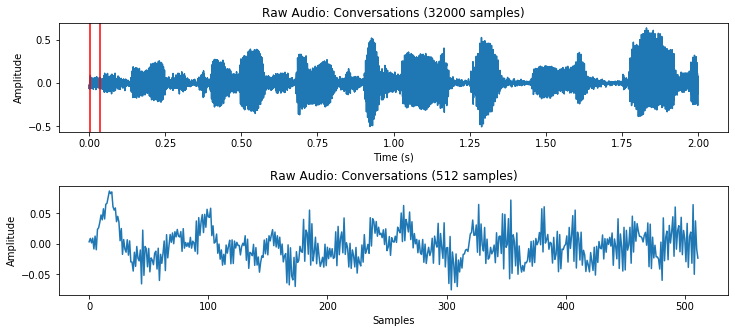

In [7]:
timesteps = np.arange(len(clip)) / sample_rate  # in seconds

fig, ax = plt.subplots(2, figsize=(12, 5))
fig.subplots_adjust(hspace=0.5)

# plot the entire clip 
ax[0].plot(timesteps, clip)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Raw Audio: {} ({} samples)'.format(row.label, len(clip)))


n_fft = 512 # frame length 
start = 45 # start at a part of the sound thats not silence.. 
x = clip[start:start+n_fft]

# mark location of frame in the entire signal
ax[0].axvline(start/sample_rate, c='r') 
ax[0].axvline((start+n_fft)/sample_rate, c='r')

# plot N samples 
ax[1].plot(x)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Raw Audio: {} ({} samples)'.format(row.label, len(x)));

In [8]:
Audio(clip, rate=sample_rate)

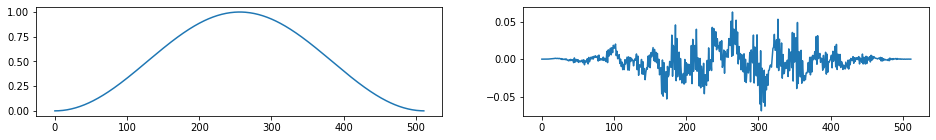

In [9]:
window = get_window('hann', n_fft)
wx = x * window

fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].plot(window)
ax[1].plot(wx);

In [10]:
# Compute (real) FFT on window
X = fft(x, n_fft)
X.shape, X.dtype

((512,), dtype('complex64'))

((257,), dtype('float32'))

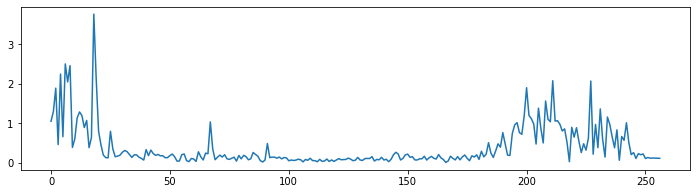

In [11]:
# We only use the first (n_fft/2)+1 numbers of the output, as the second half if redundant
X = X[:n_fft//2+1]

# Convert from rectangular to polar, usually only care about magnitude
X_magnitude, X_phase = librosa.magphase(X)

plt.plot(X_magnitude);

X_magnitude.shape, X_magnitude.dtype

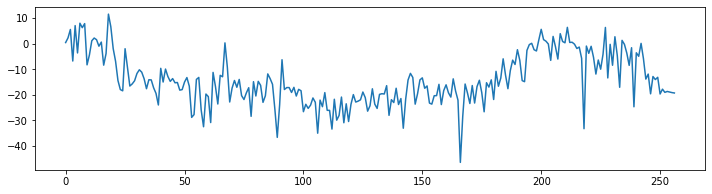

In [12]:
# we hear loudness in decibels (on a log scale of amplitude)
X_magnitude_db = librosa.amplitude_to_db(X_magnitude)

plt.plot(X_magnitude_db);

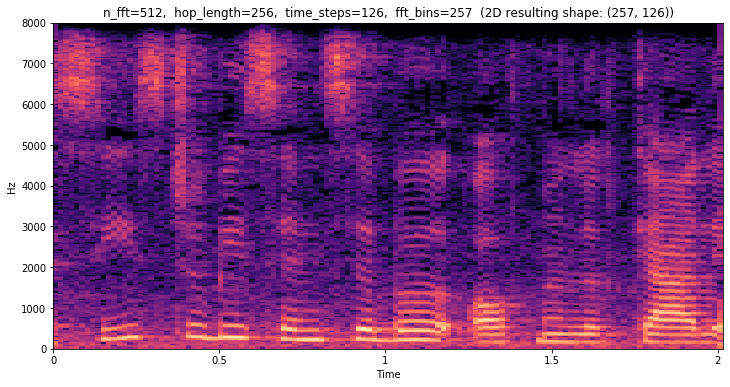

In [13]:
hop_length = 256
stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_magnitude_db, x_axis='time', y_axis='linear', 
                         sr=sample_rate, hop_length=hop_length)

title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(n_fft, hop_length, 
                       stft_magnitude_db.shape[1], 
                       stft_magnitude_db.shape[0], 
                       stft_magnitude_db.shape));

/home/ambika/.local/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


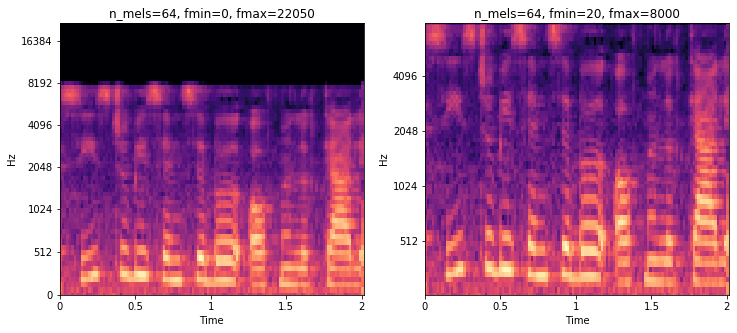

In [14]:
# number of mel frequency bands 
n_mels = 64

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

fmin = 0            
fmax = 22050# sample_rate/2
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[0])
ax[0].set_title('n_mels=64, fmin=0, fmax=22050')

fmin = 20           
fmax = 8000
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0, 
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[1])
ax[1].set_title('n_mels=64, fmin=20, fmax=8000')
# librosa.display.specshow(mel_spec_db, x_axis='linear')
plt.show()
# plt.colorbar()
# plt.tight_layout()

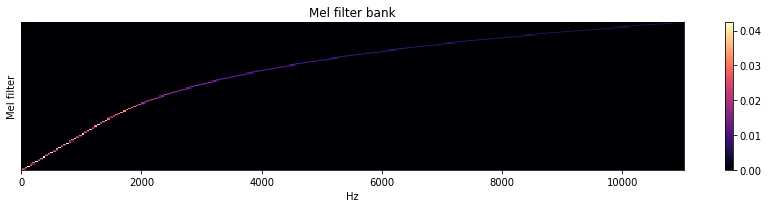

In [15]:
melfb = librosa.filters.mel(sample_rate, n_fft)
plt.figure()
librosa.display.specshow(melfb, x_axis='linear')
plt.ylabel('Mel filter')
plt.title('Mel filter bank')
plt.colorbar()
plt.tight_layout()

### Feature Extraction

In [16]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction


In [17]:
# !pip3 install eyed3 hmmlearn

In [89]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy

import time
import os
import glob
import numpy
import math
from scipy.fftpack import fft
from scipy.fftpack.realtransforms import dct
import matplotlib.pyplot as plt
from scipy.signal import lfilter

eps = 0.00000001

In [90]:
def stZCR(frame):
    """Computes zero crossing rate of frame"""
    count = len(frame)
    countZ = numpy.sum(numpy.abs(numpy.diff(numpy.sign(frame)))) / 2
    return (numpy.float64(countZ) / numpy.float64(count-1.0))

In [91]:
def stEnergy(frame):
    """Computes signal energy of frame"""
    return numpy.sum(frame ** 2) / numpy.float64(len(frame))

In [92]:
def stEnergyEntropy(frame, n_short_blocks=10):
    """Computes entropy of energy"""
    Eol = numpy.sum(frame ** 2)    # total frame energy
    L = len(frame)
    sub_win_len = int(numpy.floor(L / n_short_blocks))
    if L != sub_win_len * n_short_blocks:
            frame = frame[0:sub_win_len * n_short_blocks]
    # sub_wins is of size [n_short_blocks x L]
    sub_wins = frame.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # Compute normalized sub-frame energies:
    s = numpy.sum(sub_wins ** 2, axis=0) / (Eol + eps)

    # Compute entropy of the normalized sub-frame energies:
    Entropy = -numpy.sum(s * numpy.log2(s + eps))
    return Entropy

In [93]:
""" Frequency-domain audio features """


def stSpectralCentroidAndSpread(X, fs):
    """Computes spectral centroid of frame (given abs(FFT))"""
    ind = (numpy.arange(1, len(X) + 1)) * (fs/(2.0 * len(X)))

    Xt = X.copy()
    Xt = Xt / Xt.max()
    NUM = numpy.sum(ind * Xt)
    DEN = numpy.sum(Xt) + eps

    # Centroid:
    C = (NUM / DEN)

    # Spread:
    S = numpy.sqrt(numpy.sum(((ind - C) ** 2) * Xt) / DEN)

    # Normalize:
    C = C / (fs / 2.0)
    S = S / (fs / 2.0)

    return (C, S)

In [94]:
def stSpectralEntropy(X, n_short_blocks=10):
    """Computes the spectral entropy"""
    L = len(X)                         # number of frame samples
    Eol = numpy.sum(X ** 2)            # total spectral energy

    sub_win_len = int(numpy.floor(L / n_short_blocks))   # length of sub-frame
    if L != sub_win_len * n_short_blocks:
        X = X[0:sub_win_len * n_short_blocks]

    sub_wins = X.reshape(sub_win_len, n_short_blocks, order='F').copy()  # define sub-frames (using matrix reshape)
    s = numpy.sum(sub_wins ** 2, axis=0) / (Eol + eps)                      # compute spectral sub-energies
    En = -numpy.sum(s*numpy.log2(s + eps))                                    # compute spectral entropy

    return En

In [95]:
def stSpectralFlux(X, X_prev):
    """
    Computes the spectral flux feature of the current frame
    ARGUMENTS:
        X:            the abs(fft) of the current frame
        X_prev:        the abs(fft) of the previous frame
    """
    # compute the spectral flux as the sum of square distances:
    sumX = numpy.sum(X + eps)
    sumPrevX = numpy.sum(X_prev + eps)
    F = numpy.sum((X / sumX - X_prev/sumPrevX) ** 2)

    return F

In [96]:
def mfccInitFilterBanks(fs, nfft):
    """
    Computes the triangular filterbank for MFCC computation 
    (used in the stFeatureExtraction function before the stMFCC function call)
    This function is taken from the scikits.talkbox library (MIT Licence):
    https://pypi.python.org/pypi/scikits.talkbox
    """

    # filter bank params:
    lowfreq = 133.33
    linsc = 200/3.
    logsc = 1.0711703
    numLinFiltTotal = 13
    numLogFilt = 27

    if fs < 8000:
        nlogfil = 5

    # Total number of filters
    nFiltTotal = numLinFiltTotal + numLogFilt

    # Compute frequency points of the triangle:
    freqs = numpy.zeros(nFiltTotal+2)
    freqs[:numLinFiltTotal] = lowfreq + numpy.arange(numLinFiltTotal) * linsc
    freqs[numLinFiltTotal:] = freqs[numLinFiltTotal-1] * logsc ** numpy.arange(1, numLogFilt + 3)
    heights = 2./(freqs[2:] - freqs[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = numpy.zeros((nFiltTotal, nfft))
    nfreqs = numpy.arange(nfft) / (1. * nfft) * fs

    for i in range(nFiltTotal):
        lowTrFreq = freqs[i]
        cenTrFreq = freqs[i+1]
        highTrFreq = freqs[i+2]

        lid = numpy.arange(numpy.floor(lowTrFreq * nfft / fs) + 1, 
                           numpy.floor(cenTrFreq * nfft / fs) + 1,  
                                       dtype=numpy.int)
        lslope = heights[i] / (cenTrFreq - lowTrFreq)
        rid = numpy.arange(numpy.floor(cenTrFreq * nfft / fs) + 1, 
                                       numpy.floor(highTrFreq * nfft / fs) + 1, 
                                       dtype=numpy.int)
        rslope = heights[i] / (highTrFreq - cenTrFreq)
        fbank[i][lid] = lslope * (nfreqs[lid] - lowTrFreq)
        fbank[i][rid] = rslope * (highTrFreq - nfreqs[rid])

    return fbank, freqs


In [97]:
def stSpectralRollOff(X, c, fs):
    """Computes spectral roll-off"""
    totalEnergy = numpy.sum(X ** 2)
    fftLength = len(X)
    Thres = c*totalEnergy
    # Ffind the spectral rolloff as the frequency position 
    # where the respective spectral energy is equal to c*totalEnergy
    CumSum = numpy.cumsum(X ** 2) + eps
    [a, ] = numpy.nonzero(CumSum > Thres)
    if len(a) > 0:
        mC = numpy.float64(a[0]) / (float(fftLength))
    else:
        mC = 0.0
    return (mC)

In [98]:
def mfccInitFilterBanks(fs, nfft):
    """
    Computes the triangular filterbank for MFCC computation 
    (used in the stFeatureExtraction function before the stMFCC function call)
    This function is taken from the scikits.talkbox library (MIT Licence):
    https://pypi.python.org/pypi/scikits.talkbox
    """

    # filter bank params:
    lowfreq = 133.33
    linsc = 200/3.
    logsc = 1.0711703
    numLinFiltTotal = 13
    numLogFilt = 27

    if fs < 8000:
        nlogfil = 5

    # Total number of filters
    nFiltTotal = numLinFiltTotal + numLogFilt

    # Compute frequency points of the triangle:
    freqs = numpy.zeros(nFiltTotal+2)
    freqs[:numLinFiltTotal] = lowfreq + numpy.arange(numLinFiltTotal) * linsc
    freqs[numLinFiltTotal:] = freqs[numLinFiltTotal-1] * logsc ** numpy.arange(1, numLogFilt + 3)
    heights = 2./(freqs[2:] - freqs[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = numpy.zeros((nFiltTotal, nfft))
    nfreqs = numpy.arange(nfft) / (1. * nfft) * fs

    for i in range(nFiltTotal):
        lowTrFreq = freqs[i]
        cenTrFreq = freqs[i+1]
        highTrFreq = freqs[i+2]

        lid = numpy.arange(numpy.floor(lowTrFreq * nfft / fs) + 1, 
                           numpy.floor(cenTrFreq * nfft / fs) + 1,  
                                       dtype=numpy.int)
        lslope = heights[i] / (cenTrFreq - lowTrFreq)
        rid = numpy.arange(numpy.floor(cenTrFreq * nfft / fs) + 1, 
                                       numpy.floor(highTrFreq * nfft / fs) + 1, 
                                       dtype=numpy.int)
        rslope = heights[i] / (highTrFreq - cenTrFreq)
        fbank[i][lid] = lslope * (nfreqs[lid] - lowTrFreq)
        fbank[i][rid] = rslope * (highTrFreq - nfreqs[rid])

    return fbank, freqs


In [99]:
def stChromaFeaturesInit(nfft, fs):
    """
    This function initializes the chroma matrices used in the calculation of the chroma features
    """
    freqs = numpy.array([((f + 1) * fs) / (2 * nfft) for f in range(nfft)])    
    Cp = 27.50    
    nChroma = numpy.round(12.0 * numpy.log2(freqs / Cp)).astype(int)

    nFreqsPerChroma = numpy.zeros((nChroma.shape[0], ))

    uChroma = numpy.unique(nChroma)
    for u in uChroma:
        idx = numpy.nonzero(nChroma == u)
        nFreqsPerChroma[idx] = idx[0].shape
    
    return nChroma, nFreqsPerChroma



In [100]:
def stMFCC(X, fbank, n_mfcc_feats):
    """
    Computes the MFCCs of a frame, given the fft mag
    ARGUMENTS:
        X:        fft magnitude abs(FFT)
        fbank:    filter bank (see mfccInitFilterBanks)
    RETURN
        ceps:     MFCCs (13 element vector)
    Note:    MFCC calculation is, in general, taken from the 
             scikits.talkbox library (MIT Licence),
    #    with a small number of modifications to make it more 
         compact and suitable for the pyAudioAnalysis Lib
    """

    mspec = numpy.log10(numpy.dot(X, fbank.T)+eps)
    ceps = dct(mspec, type=2, norm='ortho', axis=-1)[:n_mfcc_feats]
    return ceps


In [104]:
def stChromaFeaturesInit(nfft, fs):
    """
    This function initializes the chroma matrices used in the calculation of the chroma features
    """
    freqs = numpy.array([((f + 1) * fs) / (2 * nfft) for f in range(nfft)])    
    Cp = 27.50    
    nChroma = numpy.round(12.0 * numpy.log2(freqs / Cp)).astype(int)

    nFreqsPerChroma = numpy.zeros((nChroma.shape[0], ))

    uChroma = numpy.unique(nChroma)
    for u in uChroma:
        idx = numpy.nonzero(nChroma == u)
        nFreqsPerChroma[idx] = idx[0].shape
    
    return nChroma, nFreqsPerChroma


In [108]:
def stChromaFeatures(X, fs, nChroma, nFreqsPerChroma):
    #TODO: 1 complexity
    #TODO: 2 bug with large windows

    chromaNames = ['A', 'A#', 'B', 'C', 'C#', 'D', 
                   'D#', 'E', 'F', 'F#', 'G', 'G#']
    spec = X**2    
    if nChroma.max()<nChroma.shape[0]:        
        C = numpy.zeros((nChroma.shape[0],))
        C[nChroma] = spec
        C /= nFreqsPerChroma[nChroma]
    else:        
        I = numpy.nonzero(nChroma>nChroma.shape[0])[0][0]        
        C = numpy.zeros((nChroma.shape[0],))
        C[nChroma[0:I-1]] = spec            
        C /= nFreqsPerChroma
    finalC = numpy.zeros((12, 1))
    newD = int(numpy.ceil(C.shape[0] / 12.0) * 12)
    C2 = numpy.zeros((newD, ))
    C2[0:C.shape[0]] = C
    C2 = C2.reshape(int(C2.shape[0]/12), 12)
    #for i in range(12):
    #    finalC[i] = numpy.sum(C[i:C.shape[0]:12])
    finalC = numpy.matrix(numpy.sum(C2, axis=0)).T
    finalC /= spec.sum()

#    ax = plt.gca()
#    plt.hold(False)
#    plt.plot(finalC)
#    ax.set_xticks(range(len(chromaNames)))
#    ax.set_xticklabels(chromaNames)
#    xaxis = numpy.arange(0, 0.02, 0.01);
#    ax.set_yticks(range(len(xaxis)))
#    ax.set_yticklabels(xaxis)
#    plt.show(block=False)
#    plt.draw()

    return chromaNames, finalC


In [109]:
def stFeatureExtraction(signal, fs, win, step):
    """
    This function implements the shor-term windowing process. For each short-term window a set of features is extracted.
    This results to a sequence of feature vectors, stored in a numpy matrix.
    ARGUMENTS
        signal:       the input signal samples
        fs:           the sampling freq (in Hz)
        win:          the short-term window size (in samples)
        step:         the short-term window step (in samples)
    RETURNS
        st_features:   a numpy array (n_feats x numOfShortTermWindows)
    """

    win = int(win)
    step = int(step)

    # Signal normalization
    signal = numpy.double(signal)

    signal = signal / (2.0 ** 15)
    DC = signal.mean()
    MAX = (numpy.abs(signal)).max()
    signal = (signal - DC) / (MAX + 0.0000000001)

    N = len(signal)                                # total number of samples
    cur_p = 0
    count_fr = 0
    nFFT = int(win / 2)

    [fbank, freqs] = mfccInitFilterBanks(fs, nFFT)                # compute the triangular filter banks used in the mfcc calculation
    nChroma, nFreqsPerChroma = stChromaFeaturesInit(nFFT, fs)

    n_time_spectral_feats = 8
    n_harmonic_feats = 0
    n_mfcc_feats = 13
    n_chroma_feats = 13
    n_total_feats = n_time_spectral_feats + n_mfcc_feats + n_harmonic_feats + n_chroma_feats
#    n_total_feats = n_time_spectral_feats + n_mfcc_feats + n_harmonic_feats
    feature_names = []
    feature_names.append("zcr")
    feature_names.append("energy")
    feature_names.append("energy_entropy")
    feature_names += ["spectral_centroid", "spectral_spread"]
    feature_names.append("spectral_entropy")
    feature_names.append("spectral_flux")
    feature_names.append("spectral_rolloff")
    feature_names += ["mfcc_{0:d}".format(mfcc_i) 
                      for mfcc_i in range(1, n_mfcc_feats+1)]
    feature_names += ["chroma_{0:d}".format(chroma_i) 
                      for chroma_i in range(1, n_chroma_feats)]
    feature_names.append("chroma_std")
    st_features = []
    while (cur_p + win - 1 < N):                        # for each short-term window until the end of signal
        count_fr += 1
        x = signal[cur_p:cur_p+win]                    # get current window
        cur_p = cur_p + step                           # update window position
        X = abs(fft(x))                                  # get fft magnitude
        X = X[0:nFFT]                                    # normalize fft
        X = X / len(X)
        if count_fr == 1:
            X_prev = X.copy()                             # keep previous fft mag (used in spectral flux)
        curFV = numpy.zeros((n_total_feats, 1))
        curFV[0] = stZCR(x)                              # zero crossing rate
        curFV[1] = stEnergy(x)                           # short-term energy
        curFV[2] = stEnergyEntropy(x)                    # short-term entropy of energy
        [curFV[3], curFV[4]] = stSpectralCentroidAndSpread(X, fs)    # spectral centroid and spread
        curFV[5] = stSpectralEntropy(X)                  # spectral entropy
        curFV[6] = stSpectralFlux(X, X_prev)              # spectral flux
        curFV[7] = stSpectralRollOff(X, 0.90, fs)        # spectral rolloff
        curFV[n_time_spectral_feats:n_time_spectral_feats+n_mfcc_feats, 0] = \
            stMFCC(X, fbank, n_mfcc_feats).copy()    # MFCCs
        chromaNames, chromaF = stChromaFeatures(X, fs, nChroma, nFreqsPerChroma)
        curFV[n_time_spectral_feats + n_mfcc_feats:
              n_time_spectral_feats + n_mfcc_feats + n_chroma_feats - 1] = \
            chromaF
        curFV[n_time_spectral_feats + n_mfcc_feats + n_chroma_feats - 1] = \
            chromaF.std()
        st_features.append(curFV)
        # delta features
        '''
        if count_fr>1:
            delta = curFV - prevFV
            curFVFinal = numpy.concatenate((curFV, delta))            
        else:
            curFVFinal = numpy.concatenate((curFV, curFV))
        prevFV = curFV
        st_features.append(curFVFinal)        
        '''
        # end of delta
        X_prev = X.copy()

    st_features = numpy.concatenate(st_features, 1)
    return st_features, feature_names

In [110]:
[fs,x]=audioBasicIO.readAudioFile('./DataClean/'+df.iloc[1].audiofile)

In [111]:
f=stFeatureExtraction(x,fs,0.050*fs,0.025*fs)

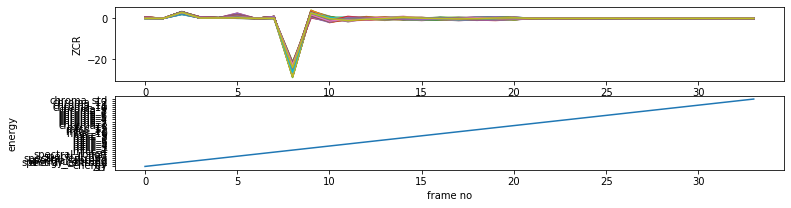

In [112]:
plt.subplot(2,1,1)
plt.plot(f[0])
plt.xlabel("frame no")
plt.ylabel("ZCR")
plt.subplot(2,1,2)
plt.plot(f[1])
plt.xlabel("frame no")
plt.ylabel("energy")
plt.show()

In [113]:
from pyAudioAnalysis import audioTrainTest as aT

### Model Training

In [114]:
from __future__ import print_function
import sys
import numpy
import os
import glob
import pickle as cPickle
import signal
import csv
import ntpath
from pyAudioAnalysis import audioFeatureExtraction as aF
from pyAudioAnalysis import audioBasicIO
from scipy import linalg as la
from scipy.spatial import distance
import sklearn.svm
import sklearn.decomposition
import sklearn.ensemble

In [115]:
def signal_handler(signal, frame):
    print('You pressed Ctrl+C! - EXIT')
    os.system("stty -cbreak echo")
    sys.exit(0)

signal.signal(signal.SIGINT, signal_handler)

shortTermWindow = 0.050
shortTermStep = 0.050
eps = 0.00000001

In [116]:
class kNN:
    def __init__(self, X, Y, k):
        self.X = X
        self.Y = Y
        self.k = k

    def classify(self, test_sample):
        n_classes = numpy.unique(self.Y).shape[0]
        y_dist = (distance.cdist(self.X,
                                 test_sample.reshape(1,
                                                     test_sample.shape[0]),
                                 'euclidean')).T
        i_sort = numpy.argsort(y_dist)
        P = numpy.zeros((n_classes,))
        for i in range(n_classes):
            P[i] = numpy.nonzero(self.Y[i_sort[0][0:self.k]] == i)[0].shape[0] / float(self.k)
        return (numpy.argmax(P), P)

In [117]:
def classifierWrapper(classifier, classifier_type, test_sample):
    '''
    This function is used as a wrapper to pattern classification.
    ARGUMENTS:
        - classifier:        a classifier object of type sklearn.svm.SVC or kNN (defined in this library) or sklearn.ensemble.RandomForestClassifier or sklearn.ensemble.GradientBoostingClassifier  or sklearn.ensemble.ExtraTreesClassifier
        - classifier_type:    "svm" or "knn" or "randomforests" or "gradientboosting" or "extratrees"
        - test_sample:        a feature vector (numpy array)
    RETURNS:
        - R:            class ID
        - P:            probability estimate
    EXAMPLE (for some audio signal stored in array x):
        import audioFeatureExtraction as aF
        import audioTrainTest as aT
        # load the classifier (here SVM, for kNN use load_model_knn instead):
        [classifier, MEAN, STD, classNames, mt_win, mt_step, st_win, st_step] = aT.load_model(model_name)
        # mid-term feature extraction:
        [mt_features, _, _] = aF.mtFeatureExtraction(x, Fs, mt_win * Fs, mt_step * Fs, round(Fs*st_win), round(Fs*st_step));
        # feature normalization:
        curFV = (mt_features[:, i] - MEAN) / STD;
        # classification
        [Result, P] = classifierWrapper(classifier, model_type, curFV)
    '''
    R = -1
    P = -1
    if classifier_type == "knn":
        [R, P] = classifier.classify(test_sample)
    elif classifier_type == "svm" or \
                    classifier_type == "randomforest" or \
                    classifier_type == "gradientboosting" or \
                    classifier_type == "extratrees" or \
                    classifier_type == "svm_rbf":
        R = classifier.predict(test_sample.reshape(1,-1))[0]
        P = classifier.predict_proba(test_sample.reshape(1,-1))[0]
    return [R, P]

In [118]:
def regressionWrapper(model, model_type, test_sample):
    '''
    This function is used as a wrapper to pattern classification.
    ARGUMENTS:
        - model:        regression model
        - model_type:        "svm" or "knn" (TODO)
        - test_sample:        a feature vector (numpy array)
    RETURNS:
        - R:            regression result (estimated value)
    EXAMPLE (for some audio signal stored in array x):
        TODO
    '''
    if model_type == "svm" or model_type == "randomforest" or model_type == "svm_rbf":
        return (model.predict(test_sample.reshape(1,-1))[0])

    #    elif classifier_type == "knn":
    #    TODO

    return None

In [119]:
def randSplitFeatures(features, per_train):
    '''
    def randSplitFeatures(features):
    This function splits a feature set for training and testing.
    ARGUMENTS:
        - features:         a list ([numOfClasses x 1]) whose elements 
                            containt numpy matrices of features.
                            each matrix features[i] of class i is 
                            [n_samples x numOfDimensions]
        - per_train:        percentage
    RETURNS:
        - featuresTrains:   a list of training data for each class
        - f_test:           a list of testing data for each class
    '''

    f_train = []
    f_test = []
    for i, f in enumerate(features):
        [n_samples, numOfDims] = f.shape
        randperm = numpy.random.permutation(range(n_samples))
        n_train = int(round(per_train * n_samples))
        f_train.append(f[randperm[0:n_train]])
        f_test.append(f[randperm[n_train::]])
    return f_train, f_test

In [120]:
def trainKNN(features, K):
    '''
    Train a kNN  classifier.
    ARGUMENTS:
        - features:         a list ([numOfClasses x 1]) whose elements containt numpy matrices of features.
                            each matrix features[i] of class i is [n_samples x numOfDimensions]
        - K:                parameter K
    RETURNS:
        - kNN:              the trained kNN variable
    '''
    [Xt, Yt] = listOfFeatures2Matrix(features)
    knn = kNN(Xt, Yt, K)
    return knn


def trainSVM(features, Cparam):
    '''
    Train a multi-class probabilitistic SVM classifier.
    Note:     This function is simply a wrapper to the sklearn functionality for SVM training
              See function trainSVM_feature() to use a wrapper on both the feature extraction and the SVM training (and parameter tuning) processes.
    ARGUMENTS:
        - features:         a list ([numOfClasses x 1]) whose elements containt numpy matrices of features
                            each matrix features[i] of class i is [n_samples x numOfDimensions]
        - Cparam:           SVM parameter C (cost of constraints violation)
    RETURNS:
        - svm:              the trained SVM variable
    NOTE:
        This function trains a linear-kernel SVM for a given C value. For a different kernel, other types of parameters should be provided.
    '''

    [X, Y] = listOfFeatures2Matrix(features)
    svm = sklearn.svm.SVC(C = Cparam, kernel = 'linear',  probability = True)        
    svm.fit(X,Y)

    return svm

def trainSVM_RBF(features, Cparam):
    '''
    Train a multi-class probabilitistic SVM classifier.
    Note:     This function is simply a wrapper to the sklearn functionality for SVM training
              See function trainSVM_feature() to use a wrapper on both the feature extraction and the SVM training (and parameter tuning) processes.
    ARGUMENTS:
        - features:         a list ([numOfClasses x 1]) whose elements containt numpy matrices of features
                            each matrix features[i] of class i is [n_samples x numOfDimensions]
        - Cparam:           SVM parameter C (cost of constraints violation)
    RETURNS:
        - svm:              the trained SVM variable
    NOTE:
        This function trains a linear-kernel SVM for a given C value. For a different kernel, other types of parameters should be provided.
    '''

    [X, Y] = listOfFeatures2Matrix(features)
    svm = sklearn.svm.SVC(C = Cparam, kernel = 'rbf',  probability = True)        
    svm.fit(X,Y)

    return svm


def trainRandomForest(features, n_estimators):
    '''
    Train a multi-class decision tree classifier.
    Note:     This function is simply a wrapper to the sklearn functionality for SVM training
              See function trainSVM_feature() to use a wrapper on both the feature extraction and the SVM training (and parameter tuning) processes.
    ARGUMENTS:
        - features:         a list ([numOfClasses x 1]) whose elements containt numpy matrices of features
                            each matrix features[i] of class i is [n_samples x numOfDimensions]
        - n_estimators:     number of trees in the forest
    RETURNS:
        - svm:              the trained SVM variable
    NOTE:
        This function trains a linear-kernel SVM for a given C value. For a different kernel, other types of parameters should be provided.
    '''

    [X, Y] = listOfFeatures2Matrix(features)
    rf = sklearn.ensemble.RandomForestClassifier(n_estimators = n_estimators)
    rf.fit(X,Y)

    return rf


def trainGradientBoosting(features, n_estimators):
    '''
    Train a gradient boosting classifier
    Note:     This function is simply a wrapper to the sklearn functionality for SVM training
              See function trainSVM_feature() to use a wrapper on both the feature extraction and the SVM training (and parameter tuning) processes.
    ARGUMENTS:
        - features:         a list ([numOfClasses x 1]) whose elements containt numpy matrices of features
                            each matrix features[i] of class i is [n_samples x numOfDimensions]
        - n_estimators:     number of trees in the forest
    RETURNS:
        - svm:              the trained SVM variable
    NOTE:
        This function trains a linear-kernel SVM for a given C value. For a different kernel, other types of parameters should be provided.
    '''

    [X, Y] = listOfFeatures2Matrix(features)
    rf = sklearn.ensemble.GradientBoostingClassifier(n_estimators = n_estimators)
    rf.fit(X,Y)

    return rf


def trainExtraTrees(features, n_estimators):
    '''
    Train a gradient boosting classifier
    Note:     This function is simply a wrapper to the sklearn functionality for extra tree classifiers
              See function trainSVM_feature() to use a wrapper on both the feature extraction and the SVM training (and parameter tuning) processes.
    ARGUMENTS:
        - features:         a list ([numOfClasses x 1]) whose elements containt numpy matrices of features
                            each matrix features[i] of class i is [n_samples x numOfDimensions]
        - n_estimators:     number of trees in the forest
    RETURNS:
        - svm:              the trained SVM variable
    NOTE:
        This function trains a linear-kernel SVM for a given C value. For a different kernel, other types of parameters should be provided.
    '''

    [X, Y] = listOfFeatures2Matrix(features)
    et = sklearn.ensemble.ExtraTreesClassifier(n_estimators = n_estimators)
    et.fit(X,Y)

    return et


def trainSVMregression(Features, Y, Cparam):    
    svm = sklearn.svm.SVR(C = Cparam, kernel = 'linear')    
    svm.fit(Features,Y)    
    train_err = numpy.mean(numpy.abs(svm.predict(Features) - Y))
    return svm, train_err


def trainSVMregression_rbf(Features, Y, Cparam):    
    svm = sklearn.svm.SVR(C = Cparam, kernel = 'rbf')    
    svm.fit(Features,Y)
    train_err = numpy.mean(numpy.abs(svm.predict(Features) - Y))
    return svm, train_err


def trainRandomForestRegression(Features, Y, n_estimators):    
    rf = sklearn.ensemble.RandomForestRegressor(n_estimators = n_estimators)
    rf.fit(Features,Y)
    train_err = numpy.mean(numpy.abs(rf.predict(Features) - Y))
    return rf, train_err

In [121]:
def featureAndTrain(list_of_dirs, mt_win, mt_step, st_win, st_step, 
                    classifier_type, model_name, 
                    compute_beat=False, perTrain=0.90):
    '''
    This function is used as a wrapper to segment-based audio feature extraction and classifier training.
    ARGUMENTS:
        list_of_dirs:        list of paths of directories. Each directory contains a signle audio class whose samples are stored in seperate WAV files.
        mt_win, mt_step:        mid-term window length and step
        st_win, st_step:        short-term window and step
        classifier_type:        "svm" or "knn" or "randomforest" or "gradientboosting" or "extratrees"
        model_name:        name of the model to be saved
    RETURNS:
        None. Resulting classifier along with the respective model parameters are saved on files.
    '''

    # STEP A: Feature Extraction:
    [features, classNames, _] = aF.dirsWavFeatureExtraction(list_of_dirs, 
                                                            mt_win, 
                                                            mt_step, 
                                                            st_win, 
                                                            st_step, 
                                                            compute_beat=compute_beat)

    if len(features) == 0:
        print("trainSVM_feature ERROR: No data found in any input folder!")
        return

    n_feats = features[0].shape[1]
    feature_names = ["features" + str(d + 1) for d in range(n_feats)]

    writeTrainDataToARFF(model_name, features, classNames, feature_names)

    for i, f in enumerate(features):
        if len(f) == 0:
            print("trainSVM_feature ERROR: " + list_of_dirs[i] + " folder is empty or non-existing!")
            return

    # STEP B: classifier Evaluation and Parameter Selection:
    if classifier_type == "svm" or classifier_type == "svm_rbf":
        classifier_par = numpy.array([0.001, 0.01,  0.5, 1.0, 5.0, 10.0, 20.0])
    elif classifier_type == "randomforest":
        classifier_par = numpy.array([10, 25, 50, 100,200,500])
    elif classifier_type == "knn":
        classifier_par = numpy.array([1, 3, 5, 7, 9, 11, 13, 15])        
    elif classifier_type == "gradientboosting":
        classifier_par = numpy.array([10, 25, 50, 100,200,500])        
    elif classifier_type == "extratrees":
        classifier_par = numpy.array([10, 25, 50, 100,200,500])        

    # get optimal classifeir parameter:
    features2 = []
    for f in features:        
        fTemp = []
        for i in range(f.shape[0]):
            temp = f[i,:]
            if (not numpy.isnan(temp).any()) and (not numpy.isinf(temp).any()) :
                fTemp.append(temp.tolist())
            else:
                print("NaN Found! Feature vector not used for training")
        features2.append(numpy.array(fTemp))
    features = features2

    bestParam = evaluateclassifier(features, classNames, 100, classifier_type, classifier_par, 0, perTrain)

    print("Selected params: {0:.5f}".format(bestParam))

    C = len(classNames)
    [features_norm, MEAN, STD] = normalizeFeatures(features)        # normalize features
    MEAN = MEAN.tolist()
    STD = STD.tolist()
    featuresNew = features_norm

    # STEP C: Save the classifier to file
    if classifier_type == "svm":
        classifier = trainSVM(featuresNew, bestParam)        
    elif classifier_type == "svm_rbf":
        classifier = trainSVM_RBF(featuresNew, bestParam)
    elif classifier_type == "randomforest":
        classifier = trainRandomForest(featuresNew, bestParam)
    elif classifier_type == "gradientboosting":
        classifier = trainGradientBoosting(featuresNew, bestParam)
    elif classifier_type == "extratrees":
        classifier = trainExtraTrees(featuresNew, bestParam)

    if classifier_type == "knn":
        [X, Y] = listOfFeatures2Matrix(featuresNew)
        X = X.tolist()
        Y = Y.tolist()
        fo = open(model_name, "wb")
        cPickle.dump(X, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(Y,  fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(MEAN, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(STD,  fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(classNames,  fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(bestParam,  fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(mt_win, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(mt_step, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(st_win, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(st_step, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(compute_beat, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        fo.close()
    elif classifier_type == "svm" or classifier_type == "svm_rbf" or \
                    classifier_type == "randomforest" or \
                    classifier_type == "gradientboosting" or \
                    classifier_type == "extratrees":
        with open(model_name, 'wb') as fid:
            cPickle.dump(classifier, fid)            
        fo = open(model_name + "MEANS", "wb")
        cPickle.dump(MEAN, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(STD, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(classNames, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(mt_win, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(mt_step, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(st_win, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(st_step, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        cPickle.dump(compute_beat, fo, protocol=cPickle.HIGHEST_PROTOCOL)
        fo.close()        

In [122]:
def featureAndTrainRegression(dir_name, mt_win, mt_step, st_win, st_step,
                              model_type, model_name, compute_beat=False):
    '''
    This function is used as a wrapper to segment-based audio feature extraction and classifier training.
    ARGUMENTS:
        dir_name:        path of directory containing the WAV files and Regression CSVs
        mt_win, mt_step:        mid-term window length and step
        st_win, st_step:        short-term window and step
        model_type:        "svm" or "knn" or "randomforest"
        model_name:        name of the model to be saved
    RETURNS:
        None. Resulting regression model along with the respective model parameters are saved on files.
    '''
    # STEP A: Feature Extraction:
    [features, _, filenames] = aF.dirsWavFeatureExtraction([dir_name],
                                                           mt_win,
                                                           mt_step,
                                                           st_win,
                                                           st_step,
                                                           compute_beat=
                                                           compute_beat)
    features = features[0]
    filenames = [ntpath.basename(f) for f in filenames[0]]
    f_final = []

    # Read CSVs:
    CSVs = glob.glob(dir_name + os.sep + "*.csv")
    regression_labels = []
    regression_names = []
    f_final = []
    for c in CSVs:                                                            # for each CSV
        cur_regression_labels = []
        f_temp = []
        with open(c, 'rt') as csvfile:                                        # open the csv file that contains the current target value's annotations
            CSVreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in CSVreader:
                if len(row) == 2:                                             # if the current row contains two fields (filename, target value)
                    if row[0] in filenames:                                   # ... and if the current filename exists in the list of filenames
                        index = filenames.index(row[0])
                        cur_regression_labels.append(float(row[1]))
                        f_temp.append(features[index,:])
                    else:
                        print("Warning: {} not found in list of files.".format(row[0]))
                else:
                    print("Warning: Row with unknown format in regression file")

        f_final.append(numpy.array(f_temp))
        regression_labels.append(numpy.array(cur_regression_labels))                          # cur_regression_labels is the list of values for the current regression problem
        regression_names.append(ntpath.basename(c).replace(".csv", ""))        # regression task name   
        if len(features) == 0:
            print("ERROR: No data found in any input folder!")
            return

    n_feats = f_final[0].shape[1]

    # TODO: ARRF WRITE????
    # STEP B: classifier Evaluation and Parameter Selection:
    if model_type == "svm" or model_type == "svm_rbf":
        model_params = numpy.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 1.0, 5.0, 10.0])        
    elif model_type == "randomforest":
        model_params = numpy.array([5, 10, 25, 50, 100])

#    elif model_type == "knn":
#        model_params = numpy.array([1, 3, 5, 7, 9, 11, 13, 15]);
    errors = []
    errors_base = []
    best_params = []

    for iRegression, r in enumerate(regression_names):
        # get optimal classifeir parameter:
        print("Regression task " + r)
        bestParam, error, berror = evaluateRegression(f_final[iRegression], 
                                                      regression_labels[iRegression], 
                                                      100, model_type, 
                                                      model_params)
        errors.append(error)
        errors_base.append(berror)
        best_params.append(bestParam)
        print("Selected params: {0:.5f}".format(bestParam))

        [features_norm, MEAN, STD] = normalizeFeatures([f_final[iRegression]])        # normalize features

        # STEP C: Save the model to file
        if model_type == "svm":
            classifier, _ = trainSVMregression(features_norm[0],
                                               regression_labels[iRegression],
                                               bestParam)
        if model_type == "svm_rbf":
            classifier, _ = trainSVMregression_rbf(features_norm[0],
                                                   regression_labels[iRegression],
                                                   bestParam)
        if model_type == "randomforest":
            classifier, _ = trainRandomForestRegression(features_norm[0],
                                                        regression_labels[iRegression],
                                                        bestParam)

        if model_type == "svm" or model_type == "svm_rbf" or model_type == "randomforest":
            with open(model_name + "_" + r, 'wb') as fid:
                cPickle.dump(classifier, fid)            
            fo = open(model_name + "_" + r + "MEANS", "wb")
            cPickle.dump(MEAN, fo, protocol=cPickle.HIGHEST_PROTOCOL)
            cPickle.dump(STD,  fo, protocol=cPickle.HIGHEST_PROTOCOL)
            cPickle.dump(mt_win, fo, protocol=cPickle.HIGHEST_PROTOCOL)
            cPickle.dump(mt_step, fo, protocol=cPickle.HIGHEST_PROTOCOL)
            cPickle.dump(st_win, fo, protocol=cPickle.HIGHEST_PROTOCOL)
            cPickle.dump(st_step, fo, protocol=cPickle.HIGHEST_PROTOCOL)
            cPickle.dump(compute_beat, fo, protocol=cPickle.HIGHEST_PROTOCOL)
            fo.close()
    return errors, errors_base, best_params


def load_model_knn(kNNModelName, is_regression=False):
    try:
        fo = open(kNNModelName, "rb")
    except IOError:
        print("didn't find file")
        return
    try:
        X = cPickle.load(fo)
        Y = cPickle.load(fo)
        MEAN = cPickle.load(fo)
        STD = cPickle.load(fo)
        if not is_regression:
            classNames = cPickle.load(fo)
        K = cPickle.load(fo)
        mt_win = cPickle.load(fo)
        mt_step = cPickle.load(fo)
        st_win = cPickle.load(fo)
        st_step = cPickle.load(fo)
        compute_beat = cPickle.load(fo)
    except:
        fo.close()
    fo.close()

    X = numpy.array(X)
    Y = numpy.array(Y)
    MEAN = numpy.array(MEAN)
    STD = numpy.array(STD)

    classifier = kNN(X, Y, K)  # Note: a direct call to the kNN constructor is used here

    if is_regression:
        return(classifier, MEAN, STD, mt_win, mt_step, st_win, st_step, compute_beat)
    else:
        return(classifier, MEAN, STD, classNames, mt_win, mt_step, st_win, st_step, compute_beat)


def load_model(model_name, is_regression=False):
    '''
    This function loads an SVM model either for classification or training.
    ARGMUMENTS:
        - SVMmodel_name:     the path of the model to be loaded
        - is_regression:     a flag indigating whereas this model is regression or not
    '''
    try:
        fo = open(model_name + "MEANS", "rb")
    except IOError:
            print("Load SVM model: Didn't find file")
            return
    try:
        MEAN = cPickle.load(fo)
        STD = cPickle.load(fo)
        if not is_regression:
            classNames = cPickle.load(fo)
        mt_win = cPickle.load(fo)
        mt_step = cPickle.load(fo)
        st_win = cPickle.load(fo)
        st_step = cPickle.load(fo)
        compute_beat = cPickle.load(fo)

    except:
        fo.close()
    fo.close()

    MEAN = numpy.array(MEAN)
    STD = numpy.array(STD)

    with open(model_name, 'rb') as fid:
        SVM = cPickle.load(fid)    

    if is_regression:
        return(SVM, MEAN, STD, mt_win, mt_step, st_win, st_step, compute_beat)
    else:
        return(SVM, MEAN, STD, classNames, mt_win, mt_step, st_win, st_step, compute_beat)


def evaluateclassifier(features, class_names, n_exp, classifier_name, Params, parameterMode, perTrain=0.90):
    '''
    ARGUMENTS:
        features:     a list ([numOfClasses x 1]) whose elements containt numpy matrices of features.
                each matrix features[i] of class i is [n_samples x numOfDimensions]
        class_names:    list of class names (strings)
        n_exp:        number of cross-validation experiments
        classifier_name: svm or knn or randomforest
        Params:        list of classifier parameters (for parameter tuning during cross-validation)
        parameterMode:    0: choose parameters that lead to maximum overall classification ACCURACY
                1: choose parameters that lead to maximum overall f1 MEASURE
    RETURNS:
         bestParam:    the value of the input parameter that optimizes the selected performance measure
    '''

    # feature normalization:
    (features_norm, MEAN, STD) = normalizeFeatures(features)
    #features_norm = features;
    n_classes = len(features)
    ac_all = []
    f1_all = []
    precision_classes_all = []
    recall_classes_all = []
    f1_classes_all = []
    cms_all = []

    # compute total number of samples:
    n_samples_total = 0
    for f in features:
        n_samples_total += f.shape[0]
    if n_samples_total > 1000 and n_exp > 50:
        n_exp = 50
        print("Number of training experiments changed to 50 due to high number of samples")
    if n_samples_total > 2000 and n_exp > 10:
        n_exp = 10
        print("Number of training experiments changed to 10 due to high number of samples")

    for Ci, C in enumerate(Params):
        # for each param value
        cm = numpy.zeros((n_classes, n_classes))
        for e in range(n_exp):
            # for each cross-validation iteration:
            print("Param = {0:.5f} - classifier Evaluation "
                  "Experiment {1:d} of {2:d}".format(C, e+1, n_exp))
            # split features:
            f_train, f_test = randSplitFeatures(features_norm, perTrain)
            # train multi-class svms:
            if classifier_name == "svm":
                classifier = trainSVM(f_train, C)
            elif classifier_name == "svm_rbf":
                classifier = trainSVM_RBF(f_train, C)
            elif classifier_name == "knn":
                classifier = trainKNN(f_train, C)
            elif classifier_name == "randomforest":
                classifier = trainRandomForest(f_train, C)
            elif classifier_name == "gradientboosting":
                classifier = trainGradientBoosting(f_train, C)
            elif classifier_name == "extratrees":
                classifier = trainExtraTrees(f_train, C)

            cmt = numpy.zeros((n_classes, n_classes))
            for c1 in range(n_classes):
                n_test_samples = len(f_test[c1])
                res = numpy.zeros((n_test_samples, 1))
                for ss in range(n_test_samples):
                    [res[ss], _] = classifierWrapper(classifier,
                                                     classifier_name,
                                                     f_test[c1][ss])
                for c2 in range(n_classes):
                    cmt[c1][c2] = float(len(numpy.nonzero(res == c2)[0]))
            cm = cm + cmt
        cm = cm + 0.0000000010
        rec = numpy.zeros((cm.shape[0], ))
        pre = numpy.zeros((cm.shape[0], ))

        for ci in range(cm.shape[0]):
            rec[ci] = cm[ci, ci] / numpy.sum(cm[ci, :])
            pre[ci] = cm[ci, ci] / numpy.sum(cm[:, ci])
        precision_classes_all.append(pre)
        recall_classes_all.append(rec)
        f1 = 2 * rec * pre / (rec + pre)
        f1_classes_all.append(f1)
        ac_all.append(numpy.sum(numpy.diagonal(cm)) / numpy.sum(cm))

        cms_all.append(cm)
        f1_all.append(numpy.mean(f1))

    print("\t\t, end=""")
    for i, c in enumerate(class_names):
        if i == len(class_names)-1:
            print("{0:s}\t\t".format(c), end="")
        else:
            print("{0:s}\t\t\t".format(c), end="")
    print("OVERALL")
    print("\tC", end="")
    for c in class_names:
        print("\tPRE\tREC\tf1", end="")
    print("\t{0:s}\t{1:s}".format("ACC", "f1"))
    best_ac_ind = numpy.argmax(ac_all)
    best_f1_ind = numpy.argmax(f1_all)
    for i in range(len(precision_classes_all)):
        print("\t{0:.3f}".format(Params[i]), end="")
        for c in range(len(precision_classes_all[i])):
            print("\t{0:.1f}\t{1:.1f}\t{2:.1f}".format(100.0 * precision_classes_all[i][c],
                                                       100.0 * recall_classes_all[i][c],
                                                       100.0 * f1_classes_all[i][c]), end="")
        print("\t{0:.1f}\t{1:.1f}".format(100.0 * ac_all[i], 100.0 * f1_all[i]), end="")
        if i == best_f1_ind:
            print("\t best f1", end="")
        if i == best_ac_ind:
            print("\t best Acc", end="")
        print("")

    if parameterMode == 0:    # keep parameters that maximize overall classification accuracy:
        print("Confusion Matrix:")
        printConfusionMatrix(cms_all[best_ac_ind], class_names)
        return Params[best_ac_ind]
    elif parameterMode == 1:  # keep parameters that maximize overall f1 measure:
        print("Confusion Matrix:")
        printConfusionMatrix(cms_all[best_f1_ind], class_names)
        return Params[best_f1_ind]


def evaluateRegression(features, labels, n_exp, method_name, Params):
    '''
    ARGUMENTS:
        features:     numpy matrices of features [n_samples x numOfDimensions]
        labels:       list of sample labels
        n_exp:         number of cross-validation experiments
        method_name:   "svm" or "randomforest"
        Params:       list of classifier params to be evaluated
    RETURNS:
         bestParam:   the value of the input parameter that optimizes the selected performance measure
    '''

    # feature normalization:
    (features_norm, MEAN, STD) = normalizeFeatures([features])
    features_norm = features_norm[0]
    n_samples = labels.shape[0]
    per_train = 0.9
    errors_all = []
    errors_train_all = []
    errors_baseline_all = []
    for Ci, C in enumerate(Params):                # for each param value
                errors = []
                errors_train = []
                errors_baseline = []
                for e in range(n_exp):             # for each cross-validation iteration:
                    # split features:
                    randperm = numpy.random.permutation(range(n_samples))
                    n_train = int(round(per_train * n_samples))
                    f_train = [features_norm[randperm[i]]
                               for i in range(n_train)]
                    f_test = [features_norm[randperm[i+n_train]]
                              for i in range(n_samples - n_train)]
                    l_train = [labels[randperm[i]] for i in range(n_train)]
                    l_test = [labels[randperm[i + n_train]]
                              for i in range(n_samples - n_train)]

                    # train multi-class svms:                    
                    f_train = numpy.matrix(f_train)                                 
                    if method_name == "svm":                                        
                        [classifier, train_err] = trainSVMregression(f_train, 
                                                                     l_train,
                                                                     C)
                    elif method_name == "svm_rbf":                      
                        [classifier, train_err] = \
                            trainSVMregression_rbf(f_train, l_train, C)
                    elif method_name == "randomforest":
                        [classifier, train_err] = \
                            trainRandomForestRegression(f_train, l_train, C)
                    error_test = []
                    error_test_baseline = []
                    for itest, fTest in enumerate(f_test):
                        R = regressionWrapper(classifier, method_name, fTest)
                        Rbaseline = numpy.mean(l_train)
                        error_test.append((R - l_test[itest]) *
                                          (R - l_test[itest]))
                        error_test_baseline.append((Rbaseline - l_test[itest]) *
                                                  (Rbaseline - l_test[itest]))
                    error = numpy.array(error_test).mean()
                    error_baseline = numpy.array(error_test_baseline).mean()
                    errors.append(error)
                    errors_train.append(train_err)
                    errors_baseline.append(error_baseline)
                errors_all.append(numpy.array(errors).mean())
                errors_train_all.append(numpy.array(errors_train).mean())
                errors_baseline_all.append(numpy.array(errors_baseline).mean())

    best_ind = numpy.argmin(errors_all)

    print("{0:s}\t\t{1:s}\t\t{2:s}\t\t{3:s}".format("Param", "MSE", "T-MSE", "R-MSE"))
    for i in range(len(errors_all)):
        print("{0:.4f}\t\t{1:.2f}\t\t{2:.2f}\t\t{3:.2f}".format(Params[i],
                                                                errors_all[i],
                                                                errors_train_all[i],
                                                                errors_baseline_all[i]),end="")
        if i == best_ind:
            print("\t\t best",end="")
        print("")
    return Params[best_ind], errors_all[best_ind], errors_baseline_all[best_ind]

In [123]:
def printConfusionMatrix(cm, class_names):
    '''
    This function prints a confusion matrix for a particular classification task.
    ARGUMENTS:
        cm:            a 2-D numpy array of the confusion matrix
                       (cm[i,j] is the number of times a sample from class i was classified in class j)
        class_names:    a list that contains the names of the classes
    '''

    if cm.shape[0] != len(class_names):
        print("printConfusionMatrix: Wrong argument sizes\n")
        return

    for c in class_names:
        if len(c) > 4:
            c = c[0:3]
        print("\t{0:s}".format(c), end="")
    print("")

    for i, c in enumerate(class_names):
        if len(c) > 4:
            c = c[0:3]
        print("{0:s}".format(c), end="")
        for j in range(len(class_names)):
            print("\t{0:.2f}".format(100.0 * cm[i][j] / numpy.sum(cm)), end="")
        print("")


def normalizeFeatures(features):
    '''
    This function normalizes a feature set to 0-mean and 1-std.
    Used in most classifier trainning cases.
    ARGUMENTS:
        - features:    list of feature matrices (each one of them is a numpy matrix)
    RETURNS:
        - features_norm:    list of NORMALIZED feature matrices
        - MEAN:        mean vector
        - STD:        std vector
    '''
    X = numpy.array([])

    for count, f in enumerate(features):
        if f.shape[0] > 0:
            if count == 0:
                X = f
            else:
                X = numpy.vstack((X, f))
            count += 1

    MEAN = numpy.mean(X, axis=0) + 0.00000000000001;
    STD = numpy.std(X, axis=0) + 0.00000000000001;

    features_norm = []
    for f in features:
        ft = f.copy()
        for n_samples in range(f.shape[0]):
            ft[n_samples, :] = (ft[n_samples, :] - MEAN) / STD
        features_norm.append(ft)
    return (features_norm, MEAN, STD)


def listOfFeatures2Matrix(features):
    '''
    listOfFeatures2Matrix(features)
    This function takes a list of feature matrices as argument and returns a single concatenated feature matrix and the respective class labels.
    ARGUMENTS:
        - features:        a list of feature matrices
    RETURNS:
        - X:            a concatenated matrix of features
        - Y:            a vector of class indeces
    '''

    X = numpy.array([])
    Y = numpy.array([])
    for i, f in enumerate(features):
        if i == 0:
            X = f
            Y = i * numpy.ones((len(f), 1))
        else:
            X = numpy.vstack((X, f))
            Y = numpy.append(Y, i * numpy.ones((len(f), 1)))
    return (X, Y)


def pcaDimRed(features, nDims):
    [X, Y] = listOfFeatures2Matrix(features)
    pca = sklearn.decomposition.PCA(n_components = nDims)
    pca.fit(X)
    coeff = pca.components_
    coeff = coeff[:, 0:nDims]

    featuresNew = []
    for f in features:
        ft = f.copy()
#        ft = pca.transform(ft, k=nDims)
        ft = numpy.dot(f, coeff)
        featuresNew.append(ft)

    return (featuresNew, coeff)


def fileClassification(inputFile, model_name, model_type):
    # Load classifier:

    if not os.path.isfile(model_name):
        print("fileClassification: input model_name not found!")
        return (-1, -1, -1)

    if not os.path.isfile(inputFile):
        print("fileClassification: wav file not found!")
        return (-1, -1, -1)

    if model_type == 'knn':
        [classifier, MEAN, STD, classNames, mt_win, mt_step, st_win, st_step,
         compute_beat] = load_model_knn(model_name)
    else:
        [classifier, MEAN, STD, classNames, mt_win, mt_step, st_win, st_step,
         compute_beat] = load_model(model_name)

    [Fs, x] = audioBasicIO.readAudioFile(inputFile)        # read audio file and convert to mono
    x = audioBasicIO.stereo2mono(x)

    if isinstance(x, int):                                 # audio file IO problem
        return (-1, -1, -1)
    if x.shape[0] / float(Fs) <= mt_win:
        return (-1, -1, -1)

    # feature extraction:
    [mt_features, s, _] = aF.mtFeatureExtraction(x, Fs, mt_win * Fs, mt_step * Fs, round(Fs * st_win), round(Fs * st_step))
    mt_features = mt_features.mean(axis=1)        # long term averaging of mid-term statistics
    if compute_beat:
        [beat, beatConf] = aF.beatExtraction(s, st_step)
        mt_features = numpy.append(mt_features, beat)
        mt_features = numpy.append(mt_features, beatConf)
    curFV = (mt_features - MEAN) / STD                # normalization

    [Result, P] = classifierWrapper(classifier, model_type, curFV)    # classification        
    return Result, P, classNames


def fileRegression(inputFile, model_name, model_type):
    # Load classifier:

    if not os.path.isfile(inputFile):
        print("fileClassification: wav file not found!")
        return (-1, -1, -1)

    regression_models = glob.glob(model_name + "_*")
    regression_models2 = []
    for r in regression_models:
        if r[-5::] != "MEANS":
            regression_models2.append(r)
    regression_models = regression_models2
    regression_names = []
    for r in regression_models:
        regression_names.append(r[r.rfind("_")+1::])

    # FEATURE EXTRACTION
    # LOAD ONLY THE FIRST MODEL (for mt_win, etc)
    if model_type == 'svm' or model_type == "svm_rbf" or model_type == 'randomforest':
        [_, _, _, mt_win, mt_step, st_win, st_step, compute_beat] = load_model(regression_models[0], True)

    [Fs, x] = audioBasicIO.readAudioFile(inputFile)        # read audio file and convert to mono
    x = audioBasicIO.stereo2mono(x)
    # feature extraction:
    [mt_features, s, _] = aF.mtFeatureExtraction(x, Fs, mt_win * Fs, mt_step * Fs, round(Fs * st_win), round(Fs * st_step))
    mt_features = mt_features.mean(axis=1)        # long term averaging of mid-term statistics
    if compute_beat:
        [beat, beatConf] = aF.beatExtraction(s, st_step)
        mt_features = numpy.append(mt_features, beat)
        mt_features = numpy.append(mt_features, beatConf)

    # REGRESSION
    R = []
    for ir, r in enumerate(regression_models):
        if not os.path.isfile(r):
            print("fileClassification: input model_name not found!")
            return (-1, -1, -1)
        if model_type == 'svm' or model_type == "svm_rbf" \
                or model_type == 'randomforest':
            [model, MEAN, STD, mt_win, mt_step, st_win, st_step, compute_beat] = \
                load_model(r, True)
        curFV = (mt_features - MEAN) / STD                  # normalization
        R.append(regressionWrapper(model, model_type, curFV))    # classification
    return R, regression_names


def lda(data, labels, redDim):
    # Centre data
    data -= data.mean(axis=0)
    n_data = numpy.shape(data)[0]
    n_dim = numpy.shape(data)[1]
    Sw = numpy.zeros((n_dim, n_dim))
    Sb = numpy.zeros((n_dim, n_dim))

    C = numpy.cov((data.T))

    # Loop over classes
    classes = numpy.unique(labels)
    for i in range(len(classes)):
        # Find relevant datapoints
        indices = (numpy.where(labels == classes[i]))
        d = numpy.squeeze(data[indices, :])
        classcov = numpy.cov((d.T))
        Sw += float(numpy.shape(indices)[0])/n_data * classcov

    Sb = C - Sw
    # Now solve for W
    # Compute eigenvalues, eigenvectors and sort into order
    evals, evecs = la.eig(Sw, Sb)
    indices = numpy.argsort(evals)
    indices = indices[::-1]
    evecs = evecs[:, indices]
    evals = evals[indices]
    w = evecs[:, :redDim]

    newData = numpy.dot(data, w)
    return newData, w


def writeTrainDataToARFF(model_name, features, classNames, feature_names):
    f = open(model_name + ".arff", 'w')
    f.write('@RELATION ' + model_name + '\n')
    for fn in feature_names:
        f.write('@ATTRIBUTE ' + fn + ' NUMERIC\n')
    f.write('@ATTRIBUTE class {')
    for c in range(len(classNames)-1):
        f.write(classNames[c] + ',')
    f.write(classNames[-1] + '}\n\n')
    f.write('@DATA\n')
    for c, fe in enumerate(features):
        for i in range(fe.shape[0]):
            for j in range(fe.shape[1]):
                f.write("{0:f},".format(fe[i, j]))
            f.write(classNames[c]+"\n")
    f.close()


def trainSpeakerModelsScript():
    '''
    This script is used to train the speaker-related models
    (NOTE: data paths are hard-coded and NOT included in the library,
    the models are, however included)
         import audioTrainTest as aT
        aT.trainSpeakerModelsScript()
    '''
    mt_win = 2.0
    mt_step = 2.0
    st_win = 0.020
    st_step = 0.020

    dir_name = "DIARIZATION_ALL/all"
    list_of_dirs = [os.path.join(dir_name, name)
                    for name in os.listdir(dir_name)
                    if os.path.isdir(os.path.join(dir_name, name))]
    featureAndTrain(list_of_dirs, mt_win, mt_step, st_win, st_step,
                    "knn", "data/knnSpeakerAll",
                    compute_beat=False, perTrain=0.50)

    dir_name = "DIARIZATION_ALL/female_male"
    list_of_dirs = [os.path.join(dir_name, name)
                    for name in os.listdir(dir_name)
                    if os.path.isdir(os.path.join(dir_name, name))]
    featureAndTrain(list_of_dirs, mt_win, mt_step, st_win, st_step,
                    "knn", "data/knnSpeakerFemaleMale",
                    compute_beat=False, perTrain=0.50)


def main(argv):
    return 0

if __name__ == '__main__':
    main(sys.argv)

#### 1. SVM

In [126]:
featureAndTrain(['./Conversations','./Human-Gathering','./Multimedia','./Outdoors','./Scream','./SobbandCry'],1.0,1.0,
                  aT.shortTermWindow,aT.shortTermStep,"svm","svm6Classes")

Analyzing file 1 of 56: ./Conversations/aditi daily14_Mar_2013_20-11-44.wav
Analyzing file 2 of 56: ./Conversations/aditi daily14_Mar_2013_20-13-01.wav
Analyzing file 3 of 56: ./Conversations/aditi daily14_Mar_2013_20-14-34.wav
Analyzing file 4 of 56: ./Conversations/aditi daily14_Mar_2013_20-15-00.wav
Analyzing file 5 of 56: ./Conversations/aditi daily14_Mar_2013_20-15-31.wav
Analyzing file 6 of 56: ./Conversations/aditi daily14_Mar_2013_20-16-02.wav
Analyzing file 7 of 56: ./Conversations/aditi sharma17_Mar_2013_19-47-08.wav
Analyzing file 8 of 56: ./Conversations/nn1_1.wav
Analyzing file 9 of 56: ./Conversations/nn1_2.wav
Analyzing file 10 of 56: ./Conversations/nn1_3.wav
Analyzing file 11 of 56: ./Conversations/nn1_4.wav
Analyzing file 12 of 56: ./Conversations/nn1_5.wav
Analyzing file 13 of 56: ./Conversations/nn26_6.wav
Analyzing file 14 of 56: ./Conversations/nn26_7.wav
Analyzing file 15 of 56: ./Conversations/nn26_8.wav
Analyzing file 16 of 56: ./Conversations/nn27_13.wav
Analy

Analyzing file 34 of 55: ./Multimedia/1380474722858.wav
Analyzing file 35 of 55: ./Multimedia/1380474730325.wav
Analyzing file 36 of 55: ./Multimedia/1380474737880.wav
Analyzing file 37 of 55: ./Multimedia/1380474745359.wav
Analyzing file 38 of 55: ./Multimedia/1380474782980.wav
Analyzing file 39 of 55: ./Multimedia/1380474790599.wav
Analyzing file 40 of 55: ./Multimedia/1380474798063.wav
Analyzing file 41 of 55: ./Multimedia/1380474805505.wav
Analyzing file 42 of 55: ./Multimedia/1380474813074.wav
Analyzing file 43 of 55: ./Multimedia/1380475791338.wav
Analyzing file 44 of 55: ./Multimedia/1380475932526.wav
Analyzing file 45 of 55: ./Multimedia/1380476014901.wav
Analyzing file 46 of 55: ./Multimedia/1380476089084.wav
Analyzing file 47 of 55: ./Multimedia/1380476170692.wav
Analyzing file 48 of 55: ./Multimedia/1380476237861.wav
Analyzing file 49 of 55: ./Multimedia/1380476319910.wav
Analyzing file 50 of 55: ./Multimedia/1385044953088.wav
Analyzing file 51 of 55: ./Multimedia/1385045631

Analyzing file 20 of 42: ./SobbandCry/Cry (27).wav
Analyzing file 21 of 42: ./SobbandCry/Cry (28).wav
Analyzing file 22 of 42: ./SobbandCry/Cry (29).wav
Analyzing file 23 of 42: ./SobbandCry/Cry (3).wav
Analyzing file 24 of 42: ./SobbandCry/Cry (30).wav
Analyzing file 25 of 42: ./SobbandCry/Cry (31).wav
Analyzing file 26 of 42: ./SobbandCry/Cry (32).wav
Analyzing file 27 of 42: ./SobbandCry/Cry (33).wav
Analyzing file 28 of 42: ./SobbandCry/Cry (34).wav
Analyzing file 29 of 42: ./SobbandCry/Cry (35).wav
Analyzing file 30 of 42: ./SobbandCry/Cry (36).wav
Analyzing file 31 of 42: ./SobbandCry/Cry (37).wav
Analyzing file 32 of 42: ./SobbandCry/Cry (38).wav
Analyzing file 33 of 42: ./SobbandCry/Cry (39).wav
Analyzing file 34 of 42: ./SobbandCry/Cry (4).wav
Analyzing file 35 of 42: ./SobbandCry/Cry (5).wav
Analyzing file 36 of 42: ./SobbandCry/Cry (6).wav
Analyzing file 37 of 42: ./SobbandCry/Cry (7).wav
Analyzing file 38 of 42: ./SobbandCry/Cry (8).wav
Analyzing file 39 of 42: ./SobbandCry

Param = 0.01000 - classifier Evaluation Experiment 23 of 100
Param = 0.01000 - classifier Evaluation Experiment 24 of 100
Param = 0.01000 - classifier Evaluation Experiment 25 of 100
Param = 0.01000 - classifier Evaluation Experiment 26 of 100
Param = 0.01000 - classifier Evaluation Experiment 27 of 100
Param = 0.01000 - classifier Evaluation Experiment 28 of 100
Param = 0.01000 - classifier Evaluation Experiment 29 of 100
Param = 0.01000 - classifier Evaluation Experiment 30 of 100
Param = 0.01000 - classifier Evaluation Experiment 31 of 100
Param = 0.01000 - classifier Evaluation Experiment 32 of 100
Param = 0.01000 - classifier Evaluation Experiment 33 of 100
Param = 0.01000 - classifier Evaluation Experiment 34 of 100
Param = 0.01000 - classifier Evaluation Experiment 35 of 100
Param = 0.01000 - classifier Evaluation Experiment 36 of 100
Param = 0.01000 - classifier Evaluation Experiment 37 of 100
Param = 0.01000 - classifier Evaluation Experiment 38 of 100
Param = 0.01000 - classi

Param = 0.50000 - classifier Evaluation Experiment 64 of 100
Param = 0.50000 - classifier Evaluation Experiment 65 of 100
Param = 0.50000 - classifier Evaluation Experiment 66 of 100
Param = 0.50000 - classifier Evaluation Experiment 67 of 100
Param = 0.50000 - classifier Evaluation Experiment 68 of 100
Param = 0.50000 - classifier Evaluation Experiment 69 of 100
Param = 0.50000 - classifier Evaluation Experiment 70 of 100
Param = 0.50000 - classifier Evaluation Experiment 71 of 100
Param = 0.50000 - classifier Evaluation Experiment 72 of 100
Param = 0.50000 - classifier Evaluation Experiment 73 of 100
Param = 0.50000 - classifier Evaluation Experiment 74 of 100
Param = 0.50000 - classifier Evaluation Experiment 75 of 100
Param = 0.50000 - classifier Evaluation Experiment 76 of 100
Param = 0.50000 - classifier Evaluation Experiment 77 of 100
Param = 0.50000 - classifier Evaluation Experiment 78 of 100
Param = 0.50000 - classifier Evaluation Experiment 79 of 100
Param = 0.50000 - classi

Param = 1.00000 - classifier Evaluation Experiment 100 of 100
Param = 5.00000 - classifier Evaluation Experiment 1 of 100
Param = 5.00000 - classifier Evaluation Experiment 2 of 100
Param = 5.00000 - classifier Evaluation Experiment 3 of 100
Param = 5.00000 - classifier Evaluation Experiment 4 of 100
Param = 5.00000 - classifier Evaluation Experiment 5 of 100
Param = 5.00000 - classifier Evaluation Experiment 6 of 100
Param = 5.00000 - classifier Evaluation Experiment 7 of 100
Param = 5.00000 - classifier Evaluation Experiment 8 of 100
Param = 5.00000 - classifier Evaluation Experiment 9 of 100
Param = 5.00000 - classifier Evaluation Experiment 10 of 100
Param = 5.00000 - classifier Evaluation Experiment 11 of 100
Param = 5.00000 - classifier Evaluation Experiment 12 of 100
Param = 5.00000 - classifier Evaluation Experiment 13 of 100
Param = 5.00000 - classifier Evaluation Experiment 14 of 100
Param = 5.00000 - classifier Evaluation Experiment 15 of 100
Param = 5.00000 - classifier Eva

Param = 10.00000 - classifier Evaluation Experiment 36 of 100
Param = 10.00000 - classifier Evaluation Experiment 37 of 100
Param = 10.00000 - classifier Evaluation Experiment 38 of 100
Param = 10.00000 - classifier Evaluation Experiment 39 of 100
Param = 10.00000 - classifier Evaluation Experiment 40 of 100
Param = 10.00000 - classifier Evaluation Experiment 41 of 100
Param = 10.00000 - classifier Evaluation Experiment 42 of 100
Param = 10.00000 - classifier Evaluation Experiment 43 of 100
Param = 10.00000 - classifier Evaluation Experiment 44 of 100
Param = 10.00000 - classifier Evaluation Experiment 45 of 100
Param = 10.00000 - classifier Evaluation Experiment 46 of 100
Param = 10.00000 - classifier Evaluation Experiment 47 of 100
Param = 10.00000 - classifier Evaluation Experiment 48 of 100
Param = 10.00000 - classifier Evaluation Experiment 49 of 100
Param = 10.00000 - classifier Evaluation Experiment 50 of 100
Param = 10.00000 - classifier Evaluation Experiment 51 of 100
Param = 

Param = 20.00000 - classifier Evaluation Experiment 72 of 100
Param = 20.00000 - classifier Evaluation Experiment 73 of 100
Param = 20.00000 - classifier Evaluation Experiment 74 of 100
Param = 20.00000 - classifier Evaluation Experiment 75 of 100
Param = 20.00000 - classifier Evaluation Experiment 76 of 100
Param = 20.00000 - classifier Evaluation Experiment 77 of 100
Param = 20.00000 - classifier Evaluation Experiment 78 of 100
Param = 20.00000 - classifier Evaluation Experiment 79 of 100
Param = 20.00000 - classifier Evaluation Experiment 80 of 100
Param = 20.00000 - classifier Evaluation Experiment 81 of 100
Param = 20.00000 - classifier Evaluation Experiment 82 of 100
Param = 20.00000 - classifier Evaluation Experiment 83 of 100
Param = 20.00000 - classifier Evaluation Experiment 84 of 100
Param = 20.00000 - classifier Evaluation Experiment 85 of 100
Param = 20.00000 - classifier Evaluation Experiment 86 of 100
Param = 20.00000 - classifier Evaluation Experiment 87 of 100
Param = 

####  2. KNN

In [125]:
featureAndTrain(['./Conversations','./Human-Gathering','./Multimedia','./Outdoors','./Scream','./SobbandCry'],1.0,1.0,
                  aT.shortTermWindow,aT.shortTermStep,"knn","knn6Classes")

Analyzing file 1 of 56: ./Conversations/aditi daily14_Mar_2013_20-11-44.wav
Analyzing file 2 of 56: ./Conversations/aditi daily14_Mar_2013_20-13-01.wav
Analyzing file 3 of 56: ./Conversations/aditi daily14_Mar_2013_20-14-34.wav
Analyzing file 4 of 56: ./Conversations/aditi daily14_Mar_2013_20-15-00.wav
Analyzing file 5 of 56: ./Conversations/aditi daily14_Mar_2013_20-15-31.wav
Analyzing file 6 of 56: ./Conversations/aditi daily14_Mar_2013_20-16-02.wav
Analyzing file 7 of 56: ./Conversations/aditi sharma17_Mar_2013_19-47-08.wav
Analyzing file 8 of 56: ./Conversations/nn1_1.wav
Analyzing file 9 of 56: ./Conversations/nn1_2.wav
Analyzing file 10 of 56: ./Conversations/nn1_3.wav
Analyzing file 11 of 56: ./Conversations/nn1_4.wav
Analyzing file 12 of 56: ./Conversations/nn1_5.wav
Analyzing file 13 of 56: ./Conversations/nn26_6.wav
Analyzing file 14 of 56: ./Conversations/nn26_7.wav
Analyzing file 15 of 56: ./Conversations/nn26_8.wav
Analyzing file 16 of 56: ./Conversations/nn27_13.wav
Analy

Analyzing file 35 of 55: ./Multimedia/1380474730325.wav
Analyzing file 36 of 55: ./Multimedia/1380474737880.wav
Analyzing file 37 of 55: ./Multimedia/1380474745359.wav
Analyzing file 38 of 55: ./Multimedia/1380474782980.wav
Analyzing file 39 of 55: ./Multimedia/1380474790599.wav
Analyzing file 40 of 55: ./Multimedia/1380474798063.wav
Analyzing file 41 of 55: ./Multimedia/1380474805505.wav
Analyzing file 42 of 55: ./Multimedia/1380474813074.wav
Analyzing file 43 of 55: ./Multimedia/1380475791338.wav
Analyzing file 44 of 55: ./Multimedia/1380475932526.wav
Analyzing file 45 of 55: ./Multimedia/1380476014901.wav
Analyzing file 46 of 55: ./Multimedia/1380476089084.wav
Analyzing file 47 of 55: ./Multimedia/1380476170692.wav
Analyzing file 48 of 55: ./Multimedia/1380476237861.wav
Analyzing file 49 of 55: ./Multimedia/1380476319910.wav
Analyzing file 50 of 55: ./Multimedia/1385044953088.wav
Analyzing file 51 of 55: ./Multimedia/1385045631311.wav
Analyzing file 52 of 55: ./Multimedia/1385045911

Analyzing file 20 of 42: ./SobbandCry/Cry (27).wav
Analyzing file 21 of 42: ./SobbandCry/Cry (28).wav
Analyzing file 22 of 42: ./SobbandCry/Cry (29).wav
Analyzing file 23 of 42: ./SobbandCry/Cry (3).wav
Analyzing file 24 of 42: ./SobbandCry/Cry (30).wav
Analyzing file 25 of 42: ./SobbandCry/Cry (31).wav
Analyzing file 26 of 42: ./SobbandCry/Cry (32).wav
Analyzing file 27 of 42: ./SobbandCry/Cry (33).wav
Analyzing file 28 of 42: ./SobbandCry/Cry (34).wav
Analyzing file 29 of 42: ./SobbandCry/Cry (35).wav
Analyzing file 30 of 42: ./SobbandCry/Cry (36).wav
Analyzing file 31 of 42: ./SobbandCry/Cry (37).wav
Analyzing file 32 of 42: ./SobbandCry/Cry (38).wav
Analyzing file 33 of 42: ./SobbandCry/Cry (39).wav
Analyzing file 34 of 42: ./SobbandCry/Cry (4).wav
Analyzing file 35 of 42: ./SobbandCry/Cry (5).wav
Analyzing file 36 of 42: ./SobbandCry/Cry (6).wav
Analyzing file 37 of 42: ./SobbandCry/Cry (7).wav
Analyzing file 38 of 42: ./SobbandCry/Cry (8).wav
Analyzing file 39 of 42: ./SobbandCry

Param = 3.00000 - classifier Evaluation Experiment 36 of 100
Param = 3.00000 - classifier Evaluation Experiment 37 of 100
Param = 3.00000 - classifier Evaluation Experiment 38 of 100
Param = 3.00000 - classifier Evaluation Experiment 39 of 100
Param = 3.00000 - classifier Evaluation Experiment 40 of 100
Param = 3.00000 - classifier Evaluation Experiment 41 of 100
Param = 3.00000 - classifier Evaluation Experiment 42 of 100
Param = 3.00000 - classifier Evaluation Experiment 43 of 100
Param = 3.00000 - classifier Evaluation Experiment 44 of 100
Param = 3.00000 - classifier Evaluation Experiment 45 of 100
Param = 3.00000 - classifier Evaluation Experiment 46 of 100
Param = 3.00000 - classifier Evaluation Experiment 47 of 100
Param = 3.00000 - classifier Evaluation Experiment 48 of 100
Param = 3.00000 - classifier Evaluation Experiment 49 of 100
Param = 3.00000 - classifier Evaluation Experiment 50 of 100
Param = 3.00000 - classifier Evaluation Experiment 51 of 100
Param = 3.00000 - classi

Param = 5.00000 - classifier Evaluation Experiment 82 of 100
Param = 5.00000 - classifier Evaluation Experiment 83 of 100
Param = 5.00000 - classifier Evaluation Experiment 84 of 100
Param = 5.00000 - classifier Evaluation Experiment 85 of 100
Param = 5.00000 - classifier Evaluation Experiment 86 of 100
Param = 5.00000 - classifier Evaluation Experiment 87 of 100
Param = 5.00000 - classifier Evaluation Experiment 88 of 100
Param = 5.00000 - classifier Evaluation Experiment 89 of 100
Param = 5.00000 - classifier Evaluation Experiment 90 of 100
Param = 5.00000 - classifier Evaluation Experiment 91 of 100
Param = 5.00000 - classifier Evaluation Experiment 92 of 100
Param = 5.00000 - classifier Evaluation Experiment 93 of 100
Param = 5.00000 - classifier Evaluation Experiment 94 of 100
Param = 5.00000 - classifier Evaluation Experiment 95 of 100
Param = 5.00000 - classifier Evaluation Experiment 96 of 100
Param = 5.00000 - classifier Evaluation Experiment 97 of 100
Param = 5.00000 - classi

Param = 9.00000 - classifier Evaluation Experiment 33 of 100
Param = 9.00000 - classifier Evaluation Experiment 34 of 100
Param = 9.00000 - classifier Evaluation Experiment 35 of 100
Param = 9.00000 - classifier Evaluation Experiment 36 of 100
Param = 9.00000 - classifier Evaluation Experiment 37 of 100
Param = 9.00000 - classifier Evaluation Experiment 38 of 100
Param = 9.00000 - classifier Evaluation Experiment 39 of 100
Param = 9.00000 - classifier Evaluation Experiment 40 of 100
Param = 9.00000 - classifier Evaluation Experiment 41 of 100
Param = 9.00000 - classifier Evaluation Experiment 42 of 100
Param = 9.00000 - classifier Evaluation Experiment 43 of 100
Param = 9.00000 - classifier Evaluation Experiment 44 of 100
Param = 9.00000 - classifier Evaluation Experiment 45 of 100
Param = 9.00000 - classifier Evaluation Experiment 46 of 100
Param = 9.00000 - classifier Evaluation Experiment 47 of 100
Param = 9.00000 - classifier Evaluation Experiment 48 of 100
Param = 9.00000 - classi

Param = 13.00000 - classifier Evaluation Experiment 9 of 100
Param = 13.00000 - classifier Evaluation Experiment 10 of 100
Param = 13.00000 - classifier Evaluation Experiment 11 of 100
Param = 13.00000 - classifier Evaluation Experiment 12 of 100
Param = 13.00000 - classifier Evaluation Experiment 13 of 100
Param = 13.00000 - classifier Evaluation Experiment 14 of 100
Param = 13.00000 - classifier Evaluation Experiment 15 of 100
Param = 13.00000 - classifier Evaluation Experiment 16 of 100
Param = 13.00000 - classifier Evaluation Experiment 17 of 100
Param = 13.00000 - classifier Evaluation Experiment 18 of 100
Param = 13.00000 - classifier Evaluation Experiment 19 of 100
Param = 13.00000 - classifier Evaluation Experiment 20 of 100
Param = 13.00000 - classifier Evaluation Experiment 21 of 100
Param = 13.00000 - classifier Evaluation Experiment 22 of 100
Param = 13.00000 - classifier Evaluation Experiment 23 of 100
Param = 13.00000 - classifier Evaluation Experiment 24 of 100
Param = 1

Param = 15.00000 - classifier Evaluation Experiment 59 of 100
Param = 15.00000 - classifier Evaluation Experiment 60 of 100
Param = 15.00000 - classifier Evaluation Experiment 61 of 100
Param = 15.00000 - classifier Evaluation Experiment 62 of 100
Param = 15.00000 - classifier Evaluation Experiment 63 of 100
Param = 15.00000 - classifier Evaluation Experiment 64 of 100
Param = 15.00000 - classifier Evaluation Experiment 65 of 100
Param = 15.00000 - classifier Evaluation Experiment 66 of 100
Param = 15.00000 - classifier Evaluation Experiment 67 of 100
Param = 15.00000 - classifier Evaluation Experiment 68 of 100
Param = 15.00000 - classifier Evaluation Experiment 69 of 100
Param = 15.00000 - classifier Evaluation Experiment 70 of 100
Param = 15.00000 - classifier Evaluation Experiment 71 of 100
Param = 15.00000 - classifier Evaluation Experiment 72 of 100
Param = 15.00000 - classifier Evaluation Experiment 73 of 100
Param = 15.00000 - classifier Evaluation Experiment 74 of 100
Param = 

####  3. Random Forest

In [25]:
aT.featureAndTrain(['./Conversations','./Human-Gathering','./Multimedia','./Outdoors','./Scream','./SobbandCry'],1.0,1.0,
                  aT.shortTermWindow,aT.shortTermStep,"randomforest","randomforest6Classes")

Analyzing file 1 of 56: ./Conversations/aditi daily14_Mar_2013_20-11-44.wav
Analyzing file 2 of 56: ./Conversations/aditi daily14_Mar_2013_20-13-01.wav
Analyzing file 3 of 56: ./Conversations/aditi daily14_Mar_2013_20-14-34.wav
Analyzing file 4 of 56: ./Conversations/aditi daily14_Mar_2013_20-15-00.wav
Analyzing file 5 of 56: ./Conversations/aditi daily14_Mar_2013_20-15-31.wav
Analyzing file 6 of 56: ./Conversations/aditi daily14_Mar_2013_20-16-02.wav
Analyzing file 7 of 56: ./Conversations/aditi sharma17_Mar_2013_19-47-08.wav
Analyzing file 8 of 56: ./Conversations/nn1_1.wav
Analyzing file 9 of 56: ./Conversations/nn1_2.wav
Analyzing file 10 of 56: ./Conversations/nn1_3.wav
Analyzing file 11 of 56: ./Conversations/nn1_4.wav
Analyzing file 12 of 56: ./Conversations/nn1_5.wav
Analyzing file 13 of 56: ./Conversations/nn26_6.wav
Analyzing file 14 of 56: ./Conversations/nn26_7.wav
Analyzing file 15 of 56: ./Conversations/nn26_8.wav
Analyzing file 16 of 56: ./Conversations/nn27_13.wav
Analy

Analyzing file 35 of 55: ./Multimedia/1380474730325.wav
Analyzing file 36 of 55: ./Multimedia/1380474737880.wav
Analyzing file 37 of 55: ./Multimedia/1380474745359.wav
Analyzing file 38 of 55: ./Multimedia/1380474782980.wav
Analyzing file 39 of 55: ./Multimedia/1380474790599.wav
Analyzing file 40 of 55: ./Multimedia/1380474798063.wav
Analyzing file 41 of 55: ./Multimedia/1380474805505.wav
Analyzing file 42 of 55: ./Multimedia/1380474813074.wav
Analyzing file 43 of 55: ./Multimedia/1380475791338.wav
Analyzing file 44 of 55: ./Multimedia/1380475932526.wav
Analyzing file 45 of 55: ./Multimedia/1380476014901.wav
Analyzing file 46 of 55: ./Multimedia/1380476089084.wav
Analyzing file 47 of 55: ./Multimedia/1380476170692.wav
Analyzing file 48 of 55: ./Multimedia/1380476237861.wav
Analyzing file 49 of 55: ./Multimedia/1380476319910.wav
Analyzing file 50 of 55: ./Multimedia/1385044953088.wav
Analyzing file 51 of 55: ./Multimedia/1385045631311.wav
Analyzing file 52 of 55: ./Multimedia/1385045911

Analyzing file 21 of 42: ./SobbandCry/Cry (28).wav
Analyzing file 22 of 42: ./SobbandCry/Cry (29).wav
Analyzing file 23 of 42: ./SobbandCry/Cry (3).wav
Analyzing file 24 of 42: ./SobbandCry/Cry (30).wav
Analyzing file 25 of 42: ./SobbandCry/Cry (31).wav
Analyzing file 26 of 42: ./SobbandCry/Cry (32).wav
Analyzing file 27 of 42: ./SobbandCry/Cry (33).wav
Analyzing file 28 of 42: ./SobbandCry/Cry (34).wav
Analyzing file 29 of 42: ./SobbandCry/Cry (35).wav
Analyzing file 30 of 42: ./SobbandCry/Cry (36).wav
Analyzing file 31 of 42: ./SobbandCry/Cry (37).wav
Analyzing file 32 of 42: ./SobbandCry/Cry (38).wav
Analyzing file 33 of 42: ./SobbandCry/Cry (39).wav
Analyzing file 34 of 42: ./SobbandCry/Cry (4).wav
Analyzing file 35 of 42: ./SobbandCry/Cry (5).wav
Analyzing file 36 of 42: ./SobbandCry/Cry (6).wav
Analyzing file 37 of 42: ./SobbandCry/Cry (7).wav
Analyzing file 38 of 42: ./SobbandCry/Cry (8).wav
Analyzing file 39 of 42: ./SobbandCry/Cry (9).wav
Analyzing file 40 of 42: ./SobbandCry/

Param = 25.00000 - classifier Evaluation Experiment 16 of 100
Param = 25.00000 - classifier Evaluation Experiment 17 of 100
Param = 25.00000 - classifier Evaluation Experiment 18 of 100
Param = 25.00000 - classifier Evaluation Experiment 19 of 100
Param = 25.00000 - classifier Evaluation Experiment 20 of 100
Param = 25.00000 - classifier Evaluation Experiment 21 of 100
Param = 25.00000 - classifier Evaluation Experiment 22 of 100
Param = 25.00000 - classifier Evaluation Experiment 23 of 100
Param = 25.00000 - classifier Evaluation Experiment 24 of 100
Param = 25.00000 - classifier Evaluation Experiment 25 of 100
Param = 25.00000 - classifier Evaluation Experiment 26 of 100
Param = 25.00000 - classifier Evaluation Experiment 27 of 100
Param = 25.00000 - classifier Evaluation Experiment 28 of 100
Param = 25.00000 - classifier Evaluation Experiment 29 of 100
Param = 25.00000 - classifier Evaluation Experiment 30 of 100
Param = 25.00000 - classifier Evaluation Experiment 31 of 100
Param = 

Param = 50.00000 - classifier Evaluation Experiment 49 of 100
Param = 50.00000 - classifier Evaluation Experiment 50 of 100
Param = 50.00000 - classifier Evaluation Experiment 51 of 100
Param = 50.00000 - classifier Evaluation Experiment 52 of 100
Param = 50.00000 - classifier Evaluation Experiment 53 of 100
Param = 50.00000 - classifier Evaluation Experiment 54 of 100
Param = 50.00000 - classifier Evaluation Experiment 55 of 100
Param = 50.00000 - classifier Evaluation Experiment 56 of 100
Param = 50.00000 - classifier Evaluation Experiment 57 of 100
Param = 50.00000 - classifier Evaluation Experiment 58 of 100
Param = 50.00000 - classifier Evaluation Experiment 59 of 100
Param = 50.00000 - classifier Evaluation Experiment 60 of 100
Param = 50.00000 - classifier Evaluation Experiment 61 of 100
Param = 50.00000 - classifier Evaluation Experiment 62 of 100
Param = 50.00000 - classifier Evaluation Experiment 63 of 100
Param = 50.00000 - classifier Evaluation Experiment 64 of 100
Param = 

Param = 100.00000 - classifier Evaluation Experiment 80 of 100
Param = 100.00000 - classifier Evaluation Experiment 81 of 100
Param = 100.00000 - classifier Evaluation Experiment 82 of 100
Param = 100.00000 - classifier Evaluation Experiment 83 of 100
Param = 100.00000 - classifier Evaluation Experiment 84 of 100
Param = 100.00000 - classifier Evaluation Experiment 85 of 100
Param = 100.00000 - classifier Evaluation Experiment 86 of 100
Param = 100.00000 - classifier Evaluation Experiment 87 of 100
Param = 100.00000 - classifier Evaluation Experiment 88 of 100
Param = 100.00000 - classifier Evaluation Experiment 89 of 100
Param = 100.00000 - classifier Evaluation Experiment 90 of 100
Param = 100.00000 - classifier Evaluation Experiment 91 of 100
Param = 100.00000 - classifier Evaluation Experiment 92 of 100
Param = 100.00000 - classifier Evaluation Experiment 93 of 100
Param = 100.00000 - classifier Evaluation Experiment 94 of 100
Param = 100.00000 - classifier Evaluation Experiment 95

Param = 500.00000 - classifier Evaluation Experiment 11 of 100
Param = 500.00000 - classifier Evaluation Experiment 12 of 100
Param = 500.00000 - classifier Evaluation Experiment 13 of 100
Param = 500.00000 - classifier Evaluation Experiment 14 of 100
Param = 500.00000 - classifier Evaluation Experiment 15 of 100
Param = 500.00000 - classifier Evaluation Experiment 16 of 100
Param = 500.00000 - classifier Evaluation Experiment 17 of 100
Param = 500.00000 - classifier Evaluation Experiment 18 of 100
Param = 500.00000 - classifier Evaluation Experiment 19 of 100
Param = 500.00000 - classifier Evaluation Experiment 20 of 100
Param = 500.00000 - classifier Evaluation Experiment 21 of 100
Param = 500.00000 - classifier Evaluation Experiment 22 of 100
Param = 500.00000 - classifier Evaluation Experiment 23 of 100
Param = 500.00000 - classifier Evaluation Experiment 24 of 100
Param = 500.00000 - classifier Evaluation Experiment 25 of 100
Param = 500.00000 - classifier Evaluation Experiment 26

#### 4. Gradient Boosting

In [127]:
featureAndTrain(['./Conversations','./Human-Gathering','./Multimedia','./Outdoors','./Scream','./SobbandCry'],1.0,1.0,
                  aT.shortTermWindow,aT.shortTermStep,"gradientboosting","gradientboostingt6Classes")

Analyzing file 1 of 56: ./Conversations/aditi daily14_Mar_2013_20-11-44.wav
Analyzing file 2 of 56: ./Conversations/aditi daily14_Mar_2013_20-13-01.wav
Analyzing file 3 of 56: ./Conversations/aditi daily14_Mar_2013_20-14-34.wav
Analyzing file 4 of 56: ./Conversations/aditi daily14_Mar_2013_20-15-00.wav
Analyzing file 5 of 56: ./Conversations/aditi daily14_Mar_2013_20-15-31.wav
Analyzing file 6 of 56: ./Conversations/aditi daily14_Mar_2013_20-16-02.wav
Analyzing file 7 of 56: ./Conversations/aditi sharma17_Mar_2013_19-47-08.wav
Analyzing file 8 of 56: ./Conversations/nn1_1.wav
Analyzing file 9 of 56: ./Conversations/nn1_2.wav
Analyzing file 10 of 56: ./Conversations/nn1_3.wav
Analyzing file 11 of 56: ./Conversations/nn1_4.wav
Analyzing file 12 of 56: ./Conversations/nn1_5.wav
Analyzing file 13 of 56: ./Conversations/nn26_6.wav
Analyzing file 14 of 56: ./Conversations/nn26_7.wav
Analyzing file 15 of 56: ./Conversations/nn26_8.wav
Analyzing file 16 of 56: ./Conversations/nn27_13.wav
Analy

Analyzing file 34 of 55: ./Multimedia/1380474722858.wav
Analyzing file 35 of 55: ./Multimedia/1380474730325.wav
Analyzing file 36 of 55: ./Multimedia/1380474737880.wav
Analyzing file 37 of 55: ./Multimedia/1380474745359.wav
Analyzing file 38 of 55: ./Multimedia/1380474782980.wav
Analyzing file 39 of 55: ./Multimedia/1380474790599.wav
Analyzing file 40 of 55: ./Multimedia/1380474798063.wav
Analyzing file 41 of 55: ./Multimedia/1380474805505.wav
Analyzing file 42 of 55: ./Multimedia/1380474813074.wav
Analyzing file 43 of 55: ./Multimedia/1380475791338.wav
Analyzing file 44 of 55: ./Multimedia/1380475932526.wav
Analyzing file 45 of 55: ./Multimedia/1380476014901.wav
Analyzing file 46 of 55: ./Multimedia/1380476089084.wav
Analyzing file 47 of 55: ./Multimedia/1380476170692.wav
Analyzing file 48 of 55: ./Multimedia/1380476237861.wav
Analyzing file 49 of 55: ./Multimedia/1380476319910.wav
Analyzing file 50 of 55: ./Multimedia/1385044953088.wav
Analyzing file 51 of 55: ./Multimedia/1385045631

Analyzing file 20 of 42: ./SobbandCry/Cry (27).wav
Analyzing file 21 of 42: ./SobbandCry/Cry (28).wav
Analyzing file 22 of 42: ./SobbandCry/Cry (29).wav
Analyzing file 23 of 42: ./SobbandCry/Cry (3).wav
Analyzing file 24 of 42: ./SobbandCry/Cry (30).wav
Analyzing file 25 of 42: ./SobbandCry/Cry (31).wav
Analyzing file 26 of 42: ./SobbandCry/Cry (32).wav
Analyzing file 27 of 42: ./SobbandCry/Cry (33).wav
Analyzing file 28 of 42: ./SobbandCry/Cry (34).wav
Analyzing file 29 of 42: ./SobbandCry/Cry (35).wav
Analyzing file 30 of 42: ./SobbandCry/Cry (36).wav
Analyzing file 31 of 42: ./SobbandCry/Cry (37).wav
Analyzing file 32 of 42: ./SobbandCry/Cry (38).wav
Analyzing file 33 of 42: ./SobbandCry/Cry (39).wav
Analyzing file 34 of 42: ./SobbandCry/Cry (4).wav
Analyzing file 35 of 42: ./SobbandCry/Cry (5).wav
Analyzing file 36 of 42: ./SobbandCry/Cry (6).wav
Analyzing file 37 of 42: ./SobbandCry/Cry (7).wav
Analyzing file 38 of 42: ./SobbandCry/Cry (8).wav
Analyzing file 39 of 42: ./SobbandCry

Param = 25.00000 - classifier Evaluation Experiment 14 of 100
Param = 25.00000 - classifier Evaluation Experiment 15 of 100
Param = 25.00000 - classifier Evaluation Experiment 16 of 100
Param = 25.00000 - classifier Evaluation Experiment 17 of 100
Param = 25.00000 - classifier Evaluation Experiment 18 of 100
Param = 25.00000 - classifier Evaluation Experiment 19 of 100
Param = 25.00000 - classifier Evaluation Experiment 20 of 100
Param = 25.00000 - classifier Evaluation Experiment 21 of 100
Param = 25.00000 - classifier Evaluation Experiment 22 of 100
Param = 25.00000 - classifier Evaluation Experiment 23 of 100
Param = 25.00000 - classifier Evaluation Experiment 24 of 100
Param = 25.00000 - classifier Evaluation Experiment 25 of 100
Param = 25.00000 - classifier Evaluation Experiment 26 of 100
Param = 25.00000 - classifier Evaluation Experiment 27 of 100
Param = 25.00000 - classifier Evaluation Experiment 28 of 100
Param = 25.00000 - classifier Evaluation Experiment 29 of 100
Param = 

Param = 50.00000 - classifier Evaluation Experiment 47 of 100
Param = 50.00000 - classifier Evaluation Experiment 48 of 100
Param = 50.00000 - classifier Evaluation Experiment 49 of 100
Param = 50.00000 - classifier Evaluation Experiment 50 of 100
Param = 50.00000 - classifier Evaluation Experiment 51 of 100
Param = 50.00000 - classifier Evaluation Experiment 52 of 100
Param = 50.00000 - classifier Evaluation Experiment 53 of 100
Param = 50.00000 - classifier Evaluation Experiment 54 of 100
Param = 50.00000 - classifier Evaluation Experiment 55 of 100
Param = 50.00000 - classifier Evaluation Experiment 56 of 100
Param = 50.00000 - classifier Evaluation Experiment 57 of 100
Param = 50.00000 - classifier Evaluation Experiment 58 of 100
Param = 50.00000 - classifier Evaluation Experiment 59 of 100
Param = 50.00000 - classifier Evaluation Experiment 60 of 100
Param = 50.00000 - classifier Evaluation Experiment 61 of 100
Param = 50.00000 - classifier Evaluation Experiment 62 of 100
Param = 

Param = 100.00000 - classifier Evaluation Experiment 79 of 100
Param = 100.00000 - classifier Evaluation Experiment 80 of 100
Param = 100.00000 - classifier Evaluation Experiment 81 of 100
Param = 100.00000 - classifier Evaluation Experiment 82 of 100
Param = 100.00000 - classifier Evaluation Experiment 83 of 100
Param = 100.00000 - classifier Evaluation Experiment 84 of 100
Param = 100.00000 - classifier Evaluation Experiment 85 of 100
Param = 100.00000 - classifier Evaluation Experiment 86 of 100
Param = 100.00000 - classifier Evaluation Experiment 87 of 100
Param = 100.00000 - classifier Evaluation Experiment 88 of 100
Param = 100.00000 - classifier Evaluation Experiment 89 of 100
Param = 100.00000 - classifier Evaluation Experiment 90 of 100
Param = 100.00000 - classifier Evaluation Experiment 91 of 100
Param = 100.00000 - classifier Evaluation Experiment 92 of 100
Param = 100.00000 - classifier Evaluation Experiment 93 of 100
Param = 100.00000 - classifier Evaluation Experiment 94

Param = 500.00000 - classifier Evaluation Experiment 10 of 100
Param = 500.00000 - classifier Evaluation Experiment 11 of 100
Param = 500.00000 - classifier Evaluation Experiment 12 of 100
Param = 500.00000 - classifier Evaluation Experiment 13 of 100
Param = 500.00000 - classifier Evaluation Experiment 14 of 100
Param = 500.00000 - classifier Evaluation Experiment 15 of 100
Param = 500.00000 - classifier Evaluation Experiment 16 of 100
Param = 500.00000 - classifier Evaluation Experiment 17 of 100
Param = 500.00000 - classifier Evaluation Experiment 18 of 100
Param = 500.00000 - classifier Evaluation Experiment 19 of 100
Param = 500.00000 - classifier Evaluation Experiment 20 of 100
Param = 500.00000 - classifier Evaluation Experiment 21 of 100
Param = 500.00000 - classifier Evaluation Experiment 22 of 100
Param = 500.00000 - classifier Evaluation Experiment 23 of 100
Param = 500.00000 - classifier Evaluation Experiment 24 of 100
Param = 500.00000 - classifier Evaluation Experiment 25

##### 5. extra trees

In [128]:
aT.featureAndTrain(['./Conversations','./Human-Gathering','./Multimedia','./Outdoors','./Scream','./SobbandCry'],1.0,1.0,
                  aT.shortTermWindow,aT.shortTermStep,"extratrees","extratreest6Classes")

Analyzing file 1 of 56: ./Conversations/aditi daily14_Mar_2013_20-11-44.wav
Analyzing file 2 of 56: ./Conversations/aditi daily14_Mar_2013_20-13-01.wav
Analyzing file 3 of 56: ./Conversations/aditi daily14_Mar_2013_20-14-34.wav
Analyzing file 4 of 56: ./Conversations/aditi daily14_Mar_2013_20-15-00.wav
Analyzing file 5 of 56: ./Conversations/aditi daily14_Mar_2013_20-15-31.wav
Analyzing file 6 of 56: ./Conversations/aditi daily14_Mar_2013_20-16-02.wav
Analyzing file 7 of 56: ./Conversations/aditi sharma17_Mar_2013_19-47-08.wav
Analyzing file 8 of 56: ./Conversations/nn1_1.wav
Analyzing file 9 of 56: ./Conversations/nn1_2.wav
Analyzing file 10 of 56: ./Conversations/nn1_3.wav
Analyzing file 11 of 56: ./Conversations/nn1_4.wav
Analyzing file 12 of 56: ./Conversations/nn1_5.wav
Analyzing file 13 of 56: ./Conversations/nn26_6.wav
Analyzing file 14 of 56: ./Conversations/nn26_7.wav
Analyzing file 15 of 56: ./Conversations/nn26_8.wav
Analyzing file 16 of 56: ./Conversations/nn27_13.wav
Analy

Analyzing file 34 of 55: ./Multimedia/1380474722858.wav
Analyzing file 35 of 55: ./Multimedia/1380474730325.wav
Analyzing file 36 of 55: ./Multimedia/1380474737880.wav
Analyzing file 37 of 55: ./Multimedia/1380474745359.wav
Analyzing file 38 of 55: ./Multimedia/1380474782980.wav
Analyzing file 39 of 55: ./Multimedia/1380474790599.wav
Analyzing file 40 of 55: ./Multimedia/1380474798063.wav
Analyzing file 41 of 55: ./Multimedia/1380474805505.wav
Analyzing file 42 of 55: ./Multimedia/1380474813074.wav
Analyzing file 43 of 55: ./Multimedia/1380475791338.wav
Analyzing file 44 of 55: ./Multimedia/1380475932526.wav
Analyzing file 45 of 55: ./Multimedia/1380476014901.wav
Analyzing file 46 of 55: ./Multimedia/1380476089084.wav
Analyzing file 47 of 55: ./Multimedia/1380476170692.wav
Analyzing file 48 of 55: ./Multimedia/1380476237861.wav
Analyzing file 49 of 55: ./Multimedia/1380476319910.wav
Analyzing file 50 of 55: ./Multimedia/1385044953088.wav
Analyzing file 51 of 55: ./Multimedia/1385045631

Analyzing file 19 of 42: ./SobbandCry/Cry (26).wav
Analyzing file 20 of 42: ./SobbandCry/Cry (27).wav
Analyzing file 21 of 42: ./SobbandCry/Cry (28).wav
Analyzing file 22 of 42: ./SobbandCry/Cry (29).wav
Analyzing file 23 of 42: ./SobbandCry/Cry (3).wav
Analyzing file 24 of 42: ./SobbandCry/Cry (30).wav
Analyzing file 25 of 42: ./SobbandCry/Cry (31).wav
Analyzing file 26 of 42: ./SobbandCry/Cry (32).wav
Analyzing file 27 of 42: ./SobbandCry/Cry (33).wav
Analyzing file 28 of 42: ./SobbandCry/Cry (34).wav
Analyzing file 29 of 42: ./SobbandCry/Cry (35).wav
Analyzing file 30 of 42: ./SobbandCry/Cry (36).wav
Analyzing file 31 of 42: ./SobbandCry/Cry (37).wav
Analyzing file 32 of 42: ./SobbandCry/Cry (38).wav
Analyzing file 33 of 42: ./SobbandCry/Cry (39).wav
Analyzing file 34 of 42: ./SobbandCry/Cry (4).wav
Analyzing file 35 of 42: ./SobbandCry/Cry (5).wav
Analyzing file 36 of 42: ./SobbandCry/Cry (6).wav
Analyzing file 37 of 42: ./SobbandCry/Cry (7).wav
Analyzing file 38 of 42: ./SobbandCr

Param = 25.00000 - classifier Evaluation Experiment 15 of 100
Param = 25.00000 - classifier Evaluation Experiment 16 of 100
Param = 25.00000 - classifier Evaluation Experiment 17 of 100
Param = 25.00000 - classifier Evaluation Experiment 18 of 100
Param = 25.00000 - classifier Evaluation Experiment 19 of 100
Param = 25.00000 - classifier Evaluation Experiment 20 of 100
Param = 25.00000 - classifier Evaluation Experiment 21 of 100
Param = 25.00000 - classifier Evaluation Experiment 22 of 100
Param = 25.00000 - classifier Evaluation Experiment 23 of 100
Param = 25.00000 - classifier Evaluation Experiment 24 of 100
Param = 25.00000 - classifier Evaluation Experiment 25 of 100
Param = 25.00000 - classifier Evaluation Experiment 26 of 100
Param = 25.00000 - classifier Evaluation Experiment 27 of 100
Param = 25.00000 - classifier Evaluation Experiment 28 of 100
Param = 25.00000 - classifier Evaluation Experiment 29 of 100
Param = 25.00000 - classifier Evaluation Experiment 30 of 100
Param = 

Param = 50.00000 - classifier Evaluation Experiment 48 of 100
Param = 50.00000 - classifier Evaluation Experiment 49 of 100
Param = 50.00000 - classifier Evaluation Experiment 50 of 100
Param = 50.00000 - classifier Evaluation Experiment 51 of 100
Param = 50.00000 - classifier Evaluation Experiment 52 of 100
Param = 50.00000 - classifier Evaluation Experiment 53 of 100
Param = 50.00000 - classifier Evaluation Experiment 54 of 100
Param = 50.00000 - classifier Evaluation Experiment 55 of 100
Param = 50.00000 - classifier Evaluation Experiment 56 of 100
Param = 50.00000 - classifier Evaluation Experiment 57 of 100
Param = 50.00000 - classifier Evaluation Experiment 58 of 100
Param = 50.00000 - classifier Evaluation Experiment 59 of 100
Param = 50.00000 - classifier Evaluation Experiment 60 of 100
Param = 50.00000 - classifier Evaluation Experiment 61 of 100
Param = 50.00000 - classifier Evaluation Experiment 62 of 100
Param = 50.00000 - classifier Evaluation Experiment 63 of 100
Param = 

Param = 100.00000 - classifier Evaluation Experiment 80 of 100
Param = 100.00000 - classifier Evaluation Experiment 81 of 100
Param = 100.00000 - classifier Evaluation Experiment 82 of 100
Param = 100.00000 - classifier Evaluation Experiment 83 of 100
Param = 100.00000 - classifier Evaluation Experiment 84 of 100
Param = 100.00000 - classifier Evaluation Experiment 85 of 100
Param = 100.00000 - classifier Evaluation Experiment 86 of 100
Param = 100.00000 - classifier Evaluation Experiment 87 of 100
Param = 100.00000 - classifier Evaluation Experiment 88 of 100
Param = 100.00000 - classifier Evaluation Experiment 89 of 100
Param = 100.00000 - classifier Evaluation Experiment 90 of 100
Param = 100.00000 - classifier Evaluation Experiment 91 of 100
Param = 100.00000 - classifier Evaluation Experiment 92 of 100
Param = 100.00000 - classifier Evaluation Experiment 93 of 100
Param = 100.00000 - classifier Evaluation Experiment 94 of 100
Param = 100.00000 - classifier Evaluation Experiment 95

Param = 500.00000 - classifier Evaluation Experiment 11 of 100
Param = 500.00000 - classifier Evaluation Experiment 12 of 100
Param = 500.00000 - classifier Evaluation Experiment 13 of 100
Param = 500.00000 - classifier Evaluation Experiment 14 of 100
Param = 500.00000 - classifier Evaluation Experiment 15 of 100
Param = 500.00000 - classifier Evaluation Experiment 16 of 100
Param = 500.00000 - classifier Evaluation Experiment 17 of 100
Param = 500.00000 - classifier Evaluation Experiment 18 of 100
Param = 500.00000 - classifier Evaluation Experiment 19 of 100
Param = 500.00000 - classifier Evaluation Experiment 20 of 100
Param = 500.00000 - classifier Evaluation Experiment 21 of 100
Param = 500.00000 - classifier Evaluation Experiment 22 of 100
Param = 500.00000 - classifier Evaluation Experiment 23 of 100
Param = 500.00000 - classifier Evaluation Experiment 24 of 100
Param = 500.00000 - classifier Evaluation Experiment 25 of 100
Param = 500.00000 - classifier Evaluation Experiment 26